#functions and libraries

In [ ]:
import pandas as pd
import numpy as np
import yellowbrick
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score , precision_score , recall_score , roc_auc_score , confusion_matrix , f1_score
from sklearn.svm import SVC ,LinearSVC
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(21, 19), dpi=80)
plt.rc('font', size=20)
plt.rc('axes', titlesize=24)    
plt.rc('axes', labelsize=24)    
plt.rc('xtick', labelsize=24)   
plt.rc('ytick', labelsize=24)  
plt.rc('legend', fontsize=20) 
plt.rc('figure', titlesize=20)
plt.rcParams["figure.figsize"] = (19,15)
plt.rcParams["font.family"] = "Times New Roman"
#in case to  return things to their previous size un-comment bellow and comment above
# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
import datetime
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
from yellowbrick.target import FeatureCorrelation
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression


def set_tags_no2(labels):
  templ=np.array(labels,dtype='object')
  for i in range(len(labels)):
    if labels[i]>200:
      templ[i]='Very unhealthy'
    elif labels[i]<=200 and labels[i]>150:
      templ[i]='Unhealthy'
    elif labels[i]<=150 and labels[i]>100:
      templ[i]='Unhealthy for sensitive group'
    elif labels[i]<=100 and labels[i]>50:
      templ[i]='Moderate'
    else:
      templ[i]='Good'
  return templ

def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

def get_score_after_permutation(model, X, y, curr_feat):
    """ return the score of model when curr_feat is permuted """

    X_permuted = X.copy()
    col_idx = list(X.columns).index(curr_feat)
    # permute one column
    X_permuted.iloc[:, col_idx] = np.random.permutation(
        X_permuted[curr_feat].values)

    permuted_score = model.score(X_permuted, y)
    return permuted_score 

def get_feature_importance(model, X, y, curr_feat):
    """ compare the score when curr_feat is permuted """

    baseline_score_train = model.score(X, y)
    permuted_score_train = get_score_after_permutation(model, X, y, curr_feat)

    # feature importance is the difference between the two scores
    feature_importance = baseline_score_train - permuted_score_train
    return feature_importance

def permutation_importance(model, X, y, n_repeats=10):
    """Calculate importance score for each feature."""

    importances = []
    for curr_feat in X.columns:
        list_feature_importance = []
        for n_round in range(n_repeats):
            list_feature_importance.append(
                get_feature_importance(model, X, y, curr_feat))

        importances.append(list_feature_importance)

    return {'importances_mean': np.mean(importances, axis=1),
            'importances_std': np.std(importances, axis=1),
            'importances': importances}

def plot_importantes_features(perm_importance_result, feat_name):
    """ bar plot the feature importance """

    fig, ax = plt.subplots(figsize=(10,20))

    indices = perm_importance_result['importances_mean'].argsort()
    y=perm_importance_result['importances_mean'][indices]
    plt.barh(range(len(indices)),
             y,
             xerr=perm_importance_result['importances_std'][indices],color='blue')

    ax.set_yticks(range(len(indices)))
    _ = ax.set_yticklabels(feat_name[indices])
    for i, v in enumerate(y):
      ax.text(0, i, str(round(v, 2)), color='black', fontweight='bold')
    plt.legend()

def correlation(ino,oto):
  X, y = ino, oto

  # Create a list of the feature names
  features = np.array(X.columns.tolist())

  # Instantiate the visualizer
  visualizer = FeatureCorrelation(labels=features)

  visualizer.fit(X, y)        # Fit the data to the visualizer
  visualizer.show()    

def confplt(classifier,X_test,y_test,class_names):
  titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
  ]
  for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    olaf=""
    if str(type(classifier).__name__)=="LGBMClassifier":
      olaf="LGBM Classifier"
    elif str(type(classifier).__name__)=="DecisionTreeClassifier":
      olaf="Decision Tree Classifier"
    elif str(type(classifier).__name__)=="KNeighborsClassifier":
      olaf="KNeighbors Classifier"
    else:
      olaf="Boosting Regression Tree Classifier"
    disp.ax_.set_title(title+" for "+olaf)
    plt.tick_params(axis=u'both', which=u'both',length=0)
    plt.grid(b=None)



<Figure size 1680x1520 with 0 Axes>

In [ ]:
# from google.colab import files
# uploaded = files.upload()

#data processing

In [ ]:
DF2018=pd.read_csv('mix2018.csv')
DF2018.reset_index(drop=True, inplace=True)

tf=DF2018['Traffic Flow'].values
twmv=np.round(tf* 0.0063)
cat=np.round(tf*0.8)
bac=np.round(tf*0.0124)
lgvs=np.round(tf*0.1813)
DF2018['two wheeled motor vehicles']=twmv
DF2018['cars and taxis']=cat
DF2018['buses and coaches']=bac
DF2018['lgvs']=lgvs

In [ ]:
labels2018=DF2018['NO2']
templ2018=set_tags_no2(labels2018)
DF2018.NO2=templ2018
trainx18,testx18,trainy18,testy18=tts(DF2018.drop('NO2', axis=1),DF2018['NO2'],test_size=0.30,random_state=300)

#Time Series

#data process

In [ ]:
DF2018=pd.read_csv('mix2018.csv')
DF2018.reset_index(drop=True, inplace=True)

tf=DF2018['Traffic Flow'].values
twmv=tf* 0.0063
cat=tf*0.8
bac=tf*0.0124
lgvs=tf*0.1813
DF2018['two wheeled motor vehicles']=twmv
DF2018['cars and taxis']=cat
DF2018['buses and coaches']=bac
DF2018['lgvs']=lgvs


DF2018=DF2018.drop('Traffic Flow',axis=1)
DF2018=DF2018.drop('Congestion',axis=1)


(1168, 1, 48) (1168,) (501, 1, 48) (501,)


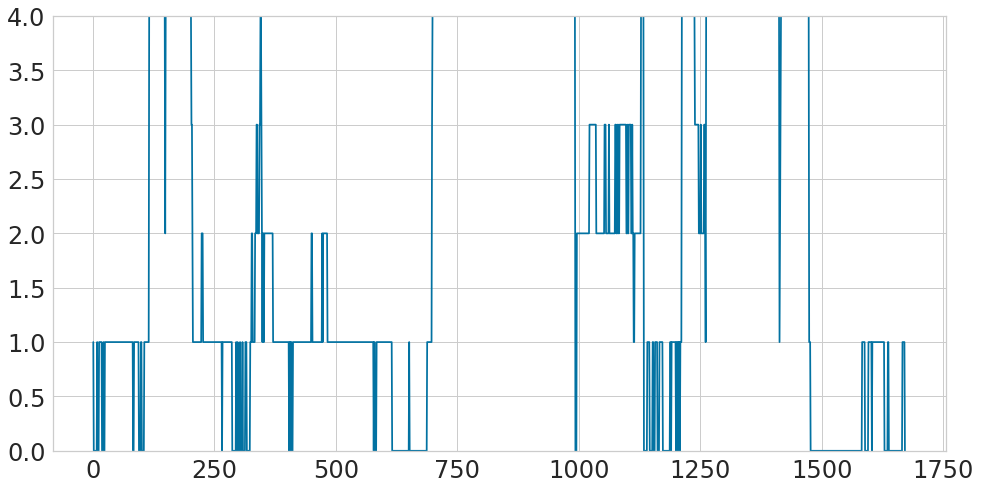

In [ ]:

DF2018.drop('hour',axis=1,inplace=True)
DF2018.reset_index(drop=True, inplace=True)

labels=DF2018['NO2'].values
templ=set_tags_no2(labels)
DF2018.NO2=templ
DF2018.fillna(0,inplace=True)

#now we have to rank the labels to numbers to
uncoded_Y=DF2018.NO2.values
Coded_Y=np.zeros(uncoded_Y.shape)
for i in range(len(uncoded_Y)):
  if(uncoded_Y[i]=='Good'):
    Coded_Y[i]=0
  elif(uncoded_Y[i]=='Moderate'):
    Coded_Y[i]=1
  elif(uncoded_Y[i]=='Unhealthy for sensitive group'):
    Coded_Y[i]=2
  elif(uncoded_Y[i]=='Unhealthy'):
    Coded_Y[i]=3
  elif(uncoded_Y[i]=='Very unhealthy'):
    Coded_Y[i]=4
DF2018.NO2=Coded_Y


DF18=DF2018
date18=[]
for i in range(len(DF18)):
  date18.append(i+1)
DF18.drop(['year','month','day'],axis=1,inplace=True)
DF18['date_by_day']=date18

DF18.index = DF18['date_by_day']
DF18=DF18.sort_index(ascending=True, axis=0)
plt.figure(figsize=(16,8))
plt.ylim(ymin=0,ymax=4)
plt.plot(DF18['NO2'], label='NO2 level')


trainx18,testx18,trainy18,testy18=tts(DF18.drop('NO2', axis=1),DF18['NO2'],test_size=0.30,random_state=300)



#process 2018 data for lstm
scaler = MinMaxScaler(feature_range=(0, 1))
values18 = scaler.fit_transform(trainx18)
trainx18 = series_to_supervised(values18, 1, 1)
tsvalues18 = scaler.fit_transform(testx18)
testx18 = series_to_supervised(tsvalues18, 1, 1)
testlab18=testy18
trainlab18=trainy18

trainx18=trainx18.values
testx18=testx18.values
trainlab18=trainlab18[1:]
testlab18=testlab18[1:]
trainx18 = trainx18.reshape((trainx18.shape[0], 1, trainx18.shape[1]))
testx18 = testx18.reshape((testx18.shape[0], 1, testx18.shape[1]))
print(trainx18.shape, trainlab18.shape, testx18.shape, testlab18.shape)



#model

Epoch 1/350
1168/1168 - 4s - loss: 2.6191 - val_loss: 2.2510 - 4s/epoch - 4ms/step
Epoch 2/350
1168/1168 - 3s - loss: 2.1650 - val_loss: 2.0923 - 3s/epoch - 2ms/step
Epoch 3/350
1168/1168 - 2s - loss: 1.9125 - val_loss: 1.7131 - 2s/epoch - 2ms/step
Epoch 4/350
1168/1168 - 2s - loss: 1.8196 - val_loss: 1.7632 - 2s/epoch - 2ms/step
Epoch 5/350
1168/1168 - 2s - loss: 1.7847 - val_loss: 2.0013 - 2s/epoch - 2ms/step
Epoch 6/350
1168/1168 - 2s - loss: 1.7105 - val_loss: 1.7175 - 2s/epoch - 2ms/step
Epoch 7/350
1168/1168 - 2s - loss: 1.6861 - val_loss: 1.9438 - 2s/epoch - 2ms/step
Epoch 8/350
1168/1168 - 3s - loss: 1.6676 - val_loss: 1.5895 - 3s/epoch - 2ms/step
Epoch 9/350
1168/1168 - 2s - loss: 1.5998 - val_loss: 1.7203 - 2s/epoch - 2ms/step
Epoch 10/350
1168/1168 - 2s - loss: 1.5995 - val_loss: 1.7359 - 2s/epoch - 2ms/step
Epoch 11/350
1168/1168 - 2s - loss: 1.5874 - val_loss: 1.6722 - 2s/epoch - 2ms/step
Epoch 12/350
1168/1168 - 3s - loss: 1.5700 - val_loss: 1.5274 - 3s/epoch - 2ms/step
E

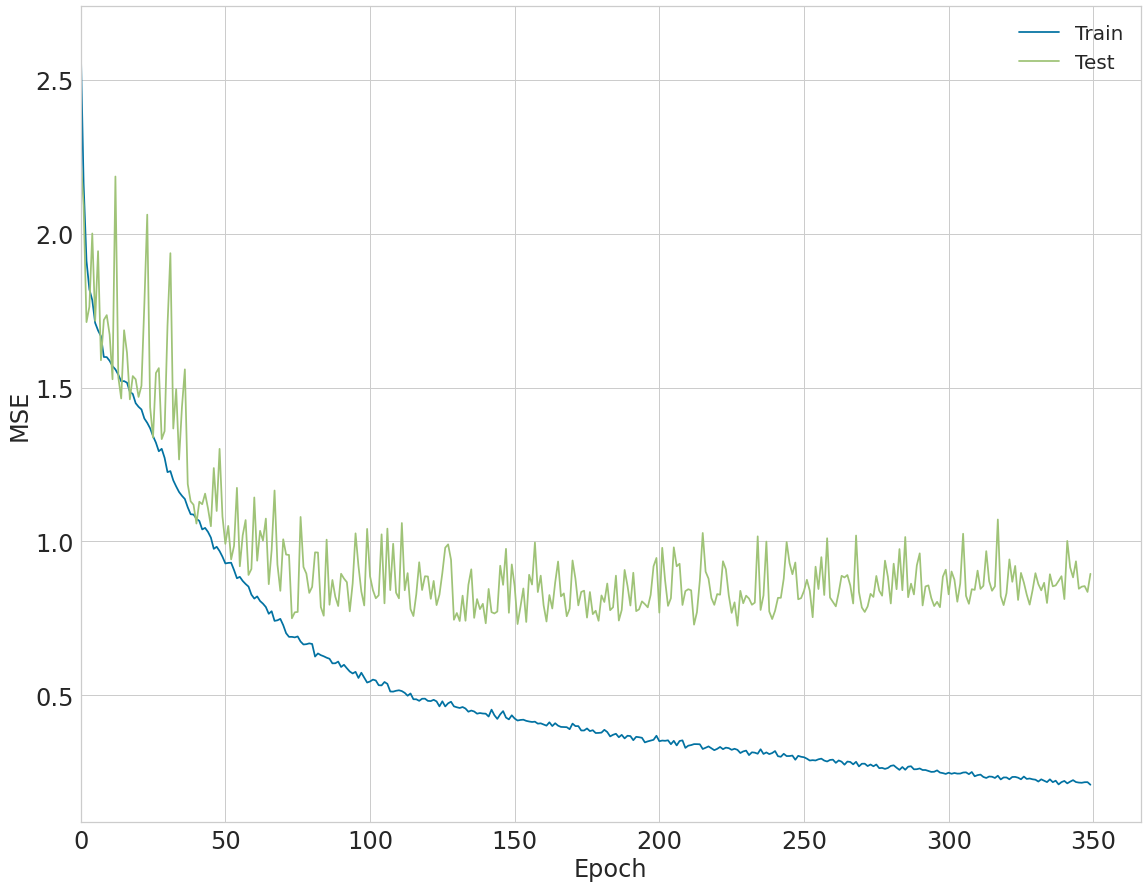

In [ ]:
#2018
model18 = Sequential()
model18.add(LSTM(200, input_shape=(trainx18.shape[1], trainx18.shape[2])))
model18.add(Dense(1))
model18.compile(loss="mean_squared_error", optimizer='sgd')
# fit network
#, 
history18pre = model18.fit(trainx18, trainlab18, epochs=350,validation_data=(testx18, testlab18), batch_size=1, verbose=2, shuffle=True)
# plot history
plt.plot(history18pre.history['loss'], label='Train')
plt.plot(history18pre.history['val_loss'], label='Test')
plt.xlabel('Epoch')
plt.xlim(xmin=0)
plt.ylabel('MSE')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
yhat18 = model18.predict(testx18)
print(yhat18.tolist())

testlab18_new=testlab18.values.tolist()
print(testlab18_new)

rmse18 = np.sqrt(mean_squared_error(testlab18, yhat18))
total_rms = np.sqrt(mean_squared_error(testlab18, np.zeros(len(testlab18_new))))
total_rms2 = np.sqrt(mean_squared_error(yhat18, np.zeros(len(testlab18_new))))
rmse18per = 100*rmse18/total_rms

print('Test RMSE for 2018: %.3f' % rmse18)
print('Test root mean square for 2018: %.3f' % total_rms)
print('Prediction root mean square for 2018: %.3f' % total_rms2)
print('Test RMSE percent for 2018: %.3f' % rmse18per)

predict_these=[2,8,10,20,30,40,50,60,70]
ys=model18.predict(testx18[predict_these,:,:])

for i in range(len(predict_these)):
  print('predicted ',np.round(ys[i]),'for day',predict_these[i],'of 2018. the true value is',testlab18_new[predict_these[i]])


[[2.393673896789551], [0.6405034065246582], [2.666334867477417], [2.6518900394439697], [3.9013071060180664], [2.008991003036499], [0.6756834983825684], [4.12183141708374], [1.632491946220398], [1.9381341934204102], [4.348015308380127], [0.6442627906799316], [2.96920108795166], [1.885232925415039], [4.057009696960449], [0.6701726913452148], [1.2569286823272705], [2.472371816635132], [2.6497669219970703], [4.509454727172852], [4.841648101806641], [1.6548447608947754], [0.3397560119628906], [0.8598818778991699], [4.904570579528809], [1.5578649044036865], [4.607653617858887], [4.126027584075928], [4.069814205169678], [1.7199376821517944], [3.914057493209839], [0.44585561752319336], [1.0875842571258545], [0.008008241653442383], [3.9798755645751953], [-0.22483563423156738], [1.8067123889923096], [4.215256690979004], [3.869309902191162], [3.6437735557556152], [0.6132900714874268], [4.152765274047852], [-0.31183886528015137], [3.742603302001953], [4.348824501037598], [1.372534155845642], [2.30

[ 1  2  3  4 10 11 12]


No handles with labels found to put in legend.


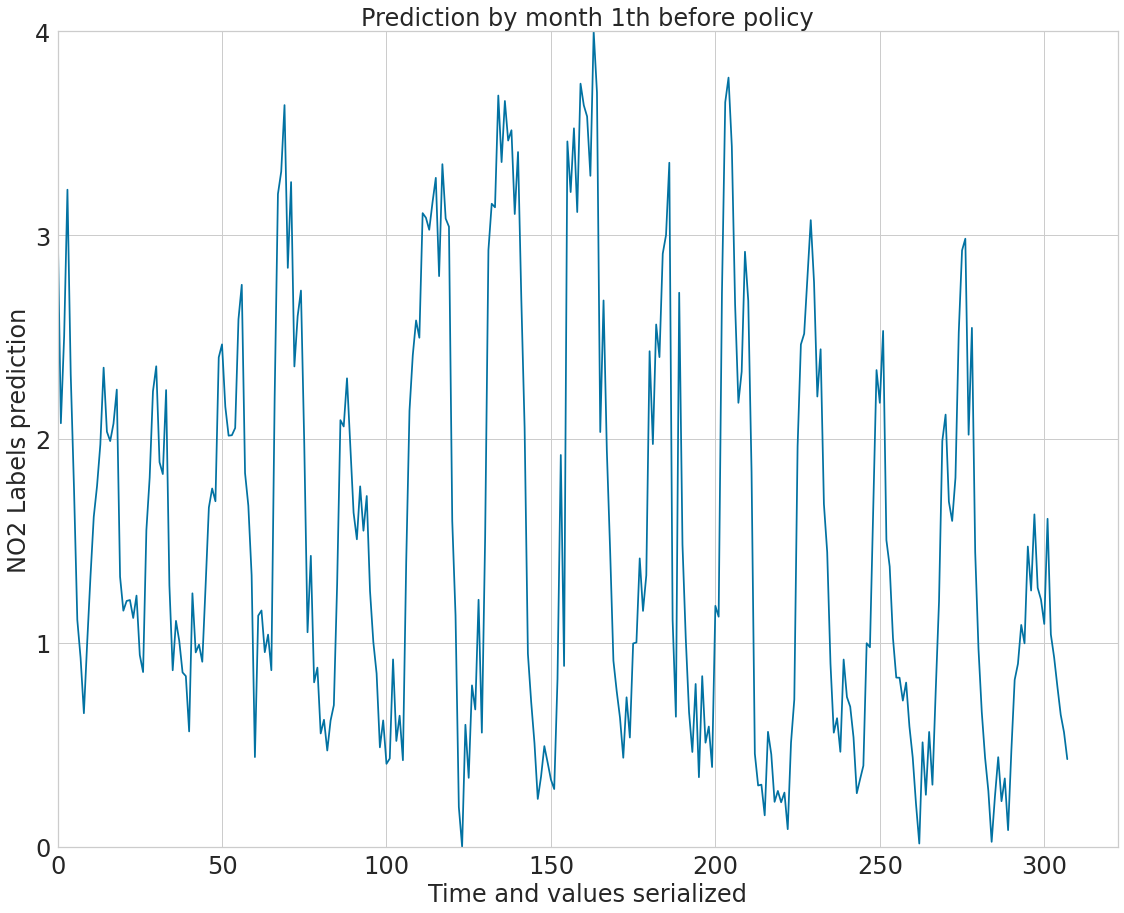

No handles with labels found to put in legend.


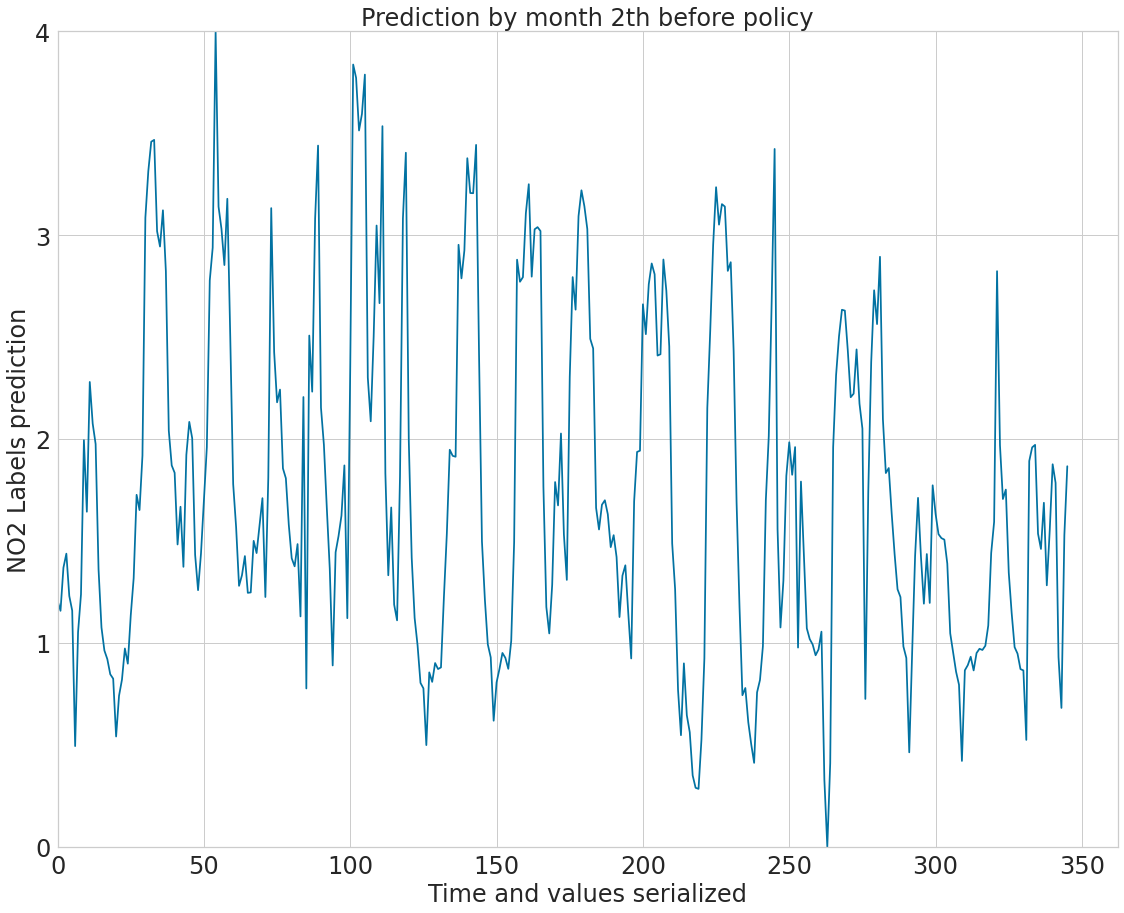

No handles with labels found to put in legend.


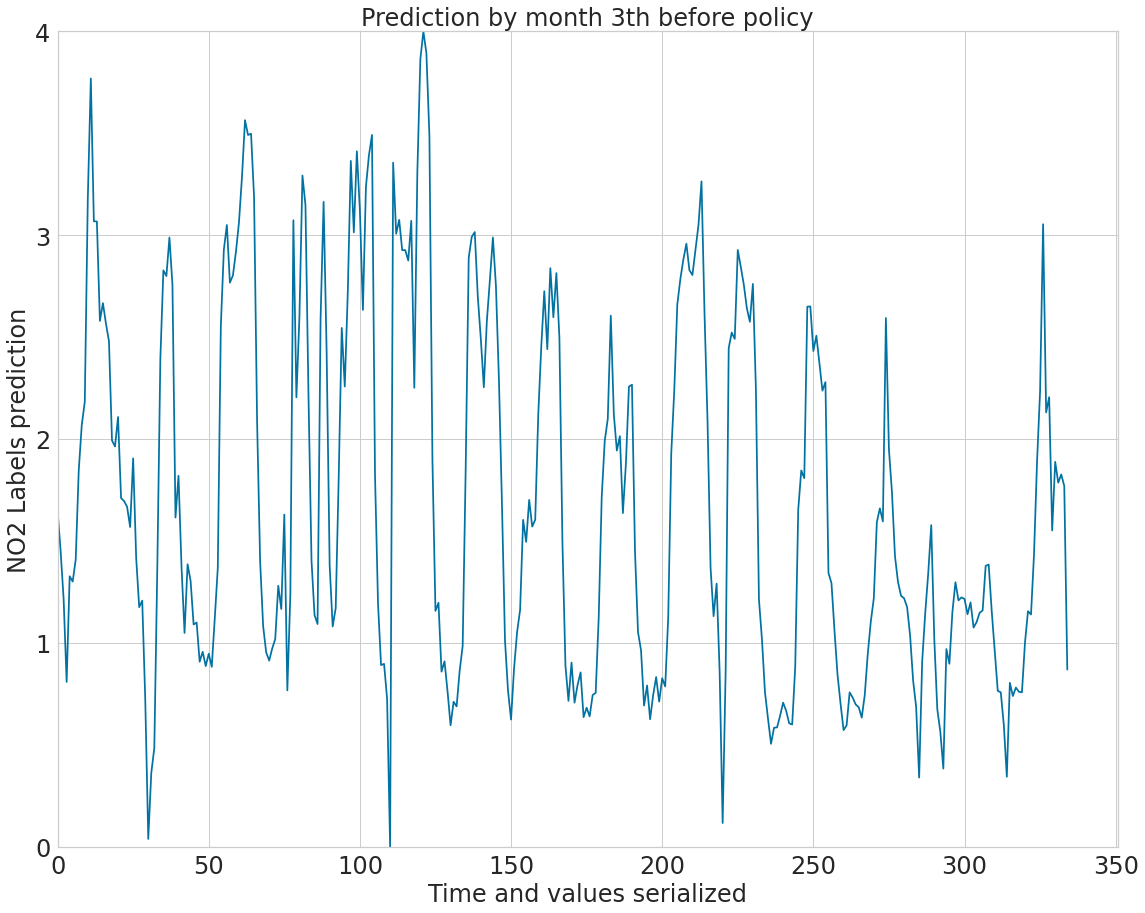

No handles with labels found to put in legend.


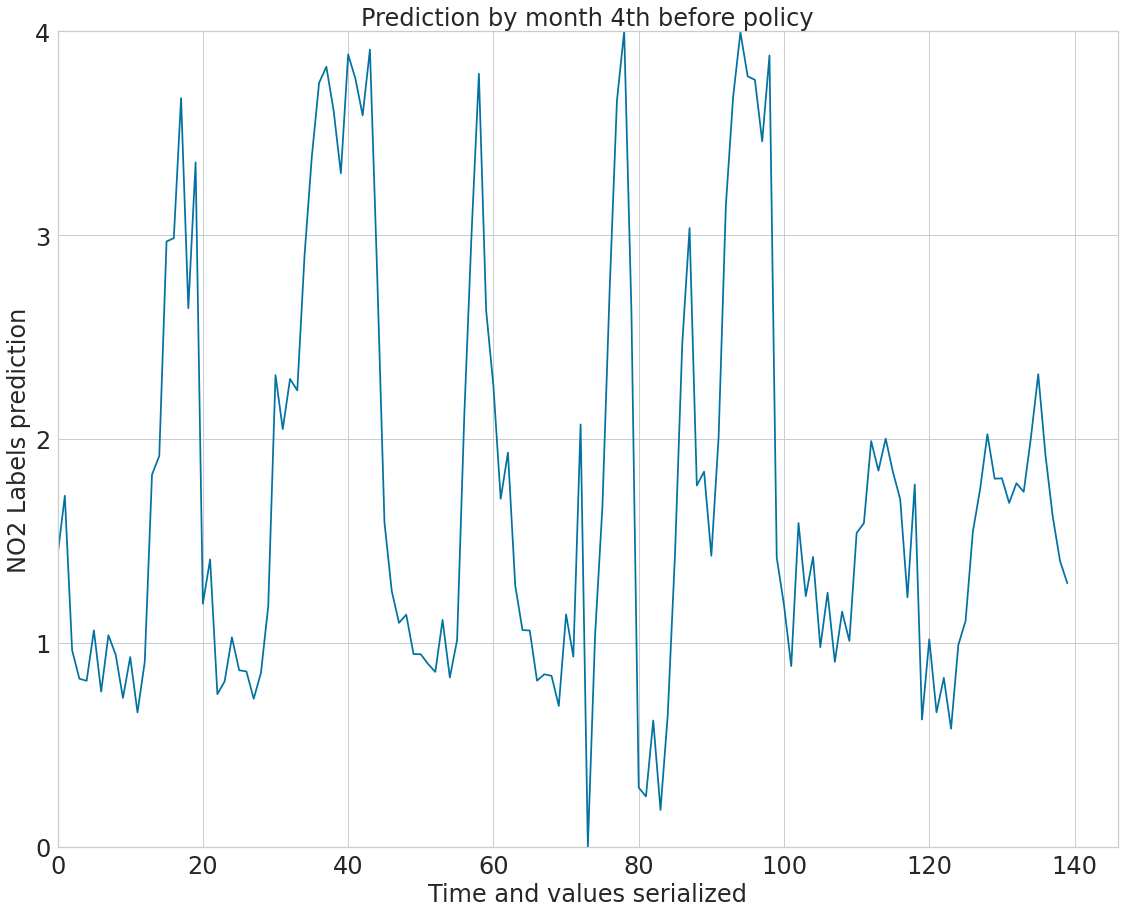

No handles with labels found to put in legend.


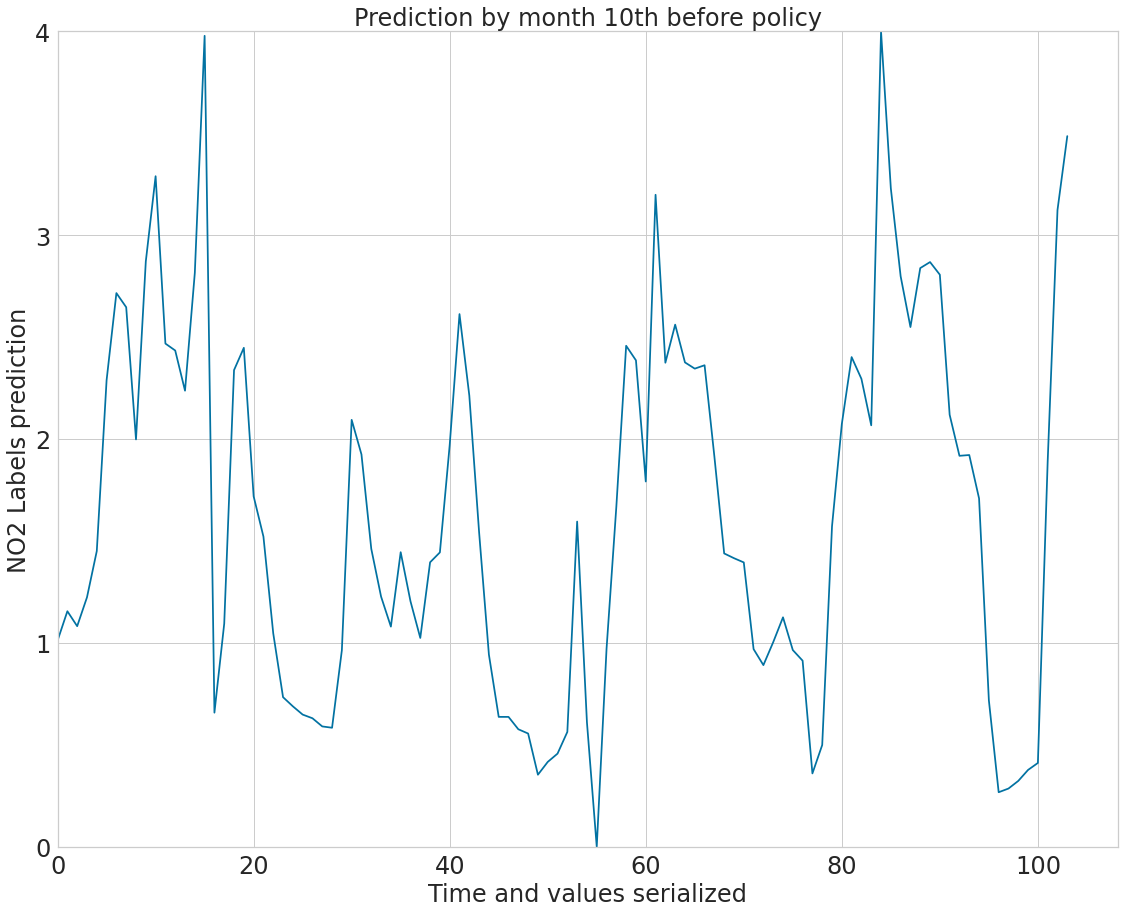

No handles with labels found to put in legend.


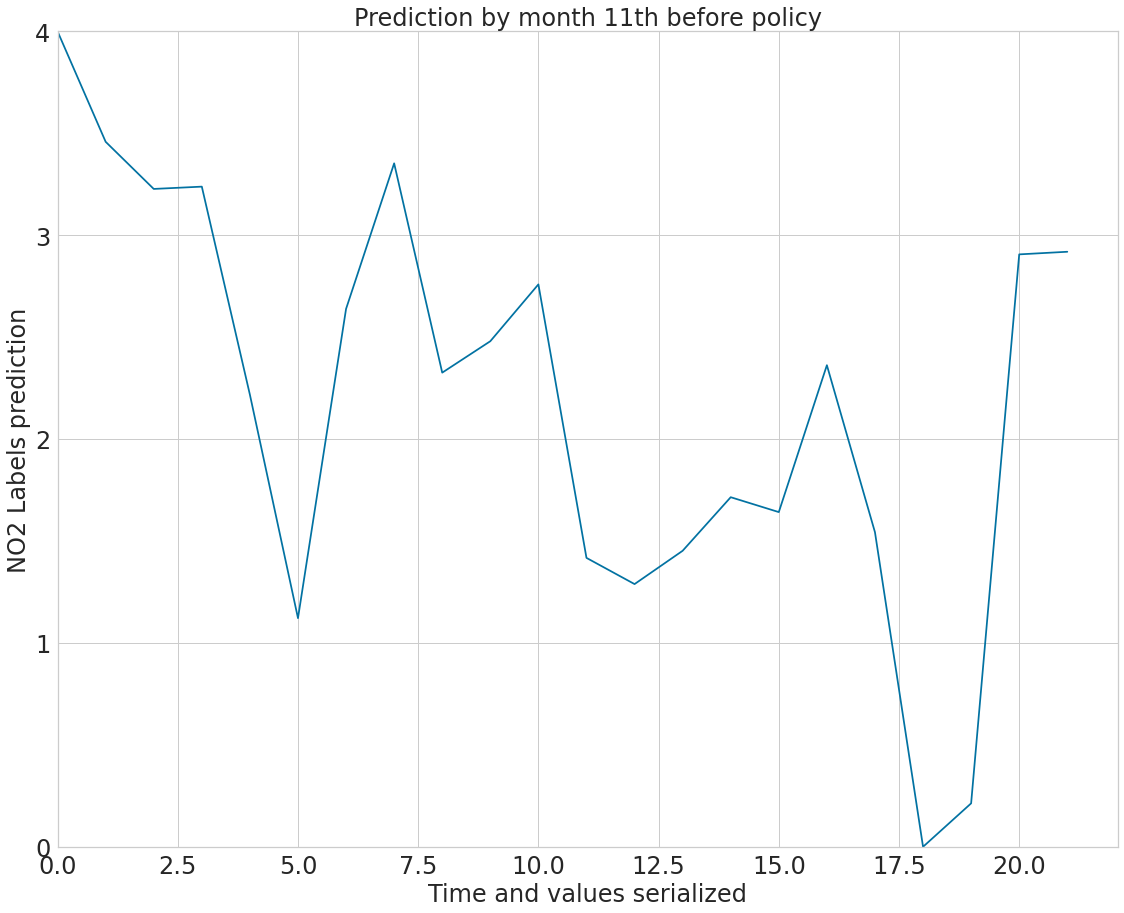

No handles with labels found to put in legend.


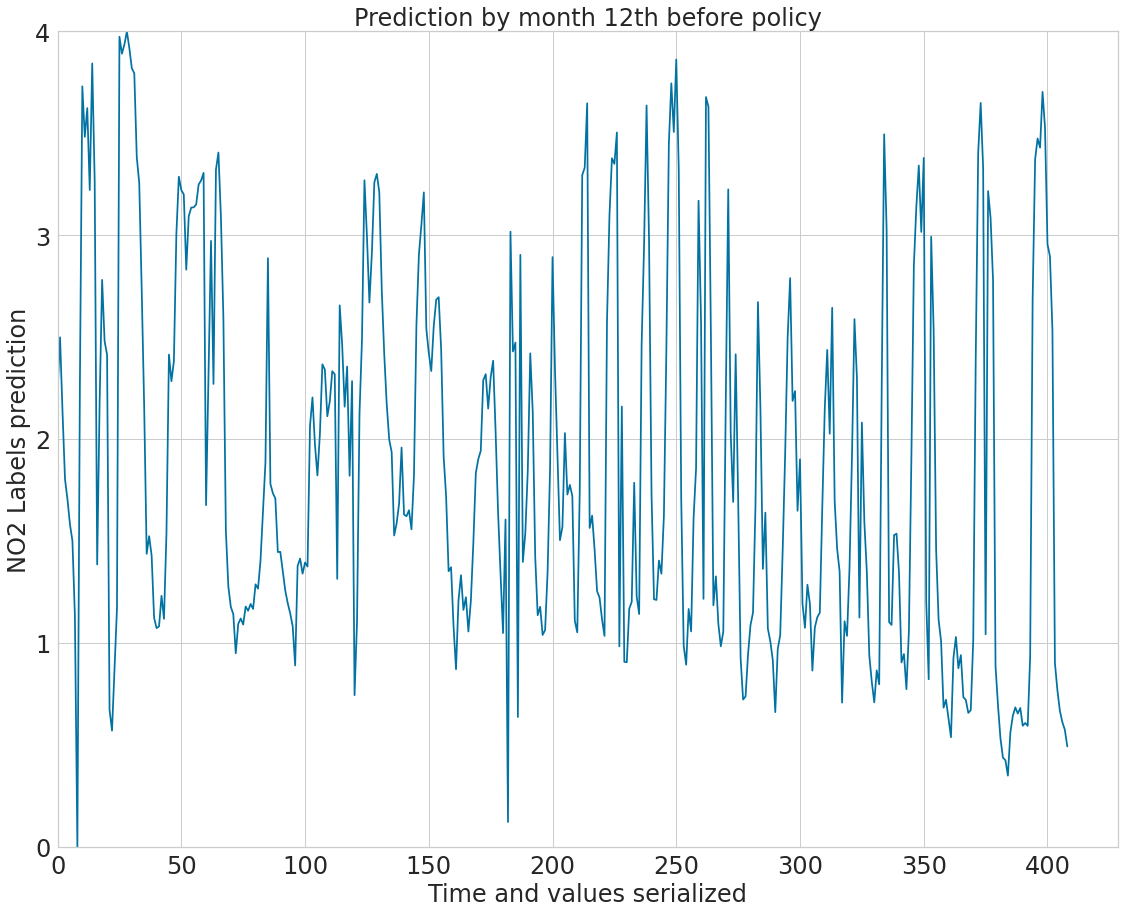

In [ ]:
DF18=pd.read_csv('mix2018.csv')
monthvals=DF18.month.unique()


tf=DF18['Traffic Flow'].values
twmv=np.round(tf* 0.0063)
cat=np.round(tf*0.8)
bac=np.round(tf*0.0124)
lgvs=np.round(tf*0.1813)
DF18['two wheeled motor vehicles']=twmv
DF18['cars and taxis']=cat
DF18['buses and coaches']=bac
DF18['lgvs']=lgvs
DF18.drop('Traffic Flow',axis=1)
labels2018=DF18['NO2']
templ2018=set_tags_no2(labels2018)
DF18.NO2=templ2018
Ys=DF18["NO2"].values
Ys_of_train=np.zeros_like(Ys)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4

DF18.NO2=Ys_of_train


print(monthvals)
for j in monthvals:

  tempdf=DF18.loc[DF18['month'] == j]
  trainx18=tempdf.drop('NO2', axis=1)
  
  scaler = MinMaxScaler(feature_range=(0, 1))
  values18 = scaler.fit_transform(trainx18)
  trainx18 = series_to_supervised(values18, 1, 1)
  trainlab18=tempdf['NO2'].values

  trainx18=trainx18.values
  trainlab18=trainlab18[:48]
  trainx18 = trainx18.reshape((trainx18.shape[0], 1, trainx18.shape[1]))
  trainx18 =trainx18[:,:,:48]
  yhats = model18.predict(trainx18)
  scaler = MinMaxScaler(feature_range=(0, 4))
  yhats = scaler.fit_transform(yhats)
  plt.plot(yhats)
  plt.yticks([0,1,2,3,4])
  plt.xlabel('Time and values serialized')
  plt.ylabel('NO2 Labels prediction')
  plt.title('Prediction by month '+str(j)+'th before policy')
  # 1st 2nd 3rd 4th 5th 6th 7th
  plt.xlim(xmin=0)
  plt.ylim(ymin=0,ymax=4)
  plt.legend()
  plt.show()

#Policy

In [ ]:
#first import datasets
DF18=pd.read_csv('mix2018.csv')

DF18.reset_index(drop=True, inplace=True)


tf=DF18['Traffic Flow'].values
twmv=np.round(tf* 0.0063)
cat=np.round(tf*0.8)
bac=np.round(tf*0.0124)
lgvs=np.round(tf*0.1813)
DF18['two wheeled motor vehicles']=twmv
DF18['cars and taxis']=cat
DF18['buses and coaches']=bac
DF18['lgvs']=lgvs

DF18=DF18.drop('Traffic Flow',axis=1)
DF18=DF18.drop('Congestion',axis=1)


DF18.drop('hour',axis=1,inplace=True)
DF18.reset_index(drop=True, inplace=True)




# 18
twmv18=DF18["two wheeled motor vehicles"].values
twmv18=np.round(twmv18*0.8)
cat18=DF18["cars and taxis"].values
cat18=np.round(cat18*0.8)
bac18=DF18["buses and coaches"].values
bac18=np.round(bac18*0.9)
lgvs18=DF18["lgvs"].values
lgvs18=np.round(lgvs18*0.8)
co18=DF18["CO"].values
co18=co18-18
pm2518=DF18["PM2_5"].values
pm2518=pm2518 -16
par18=DF18["Particle Count"].values
par18=par18 -10
pm118=DF18["PM1"].values
pm118=pm118 -10
pm1018=DF18["PM10"].values
pm1018=pm1018 -21
pm418=DF18["PM 4"].values
pm418=pm418 -23
o318=DF18["O3"].values
o318=o318 -29
no18=DF18["NO"].values
no18=no18 -18
nox18=DF18["NOx"].values
nox18=nox18 -24
no218=DF18["NO2"].values
no218=no218 -25


DF18["two wheeled motor vehicles"]=twmv18
DF18["cars and taxis"]=cat18
DF18["buses and coaches"]=bac18
DF18["lgvs"]=lgvs18
DF18["CO"]=co18
DF18["PM2_5"]=pm2518
DF18["Particle Count"]=par18
DF18["PM1"]=pm118
DF18["PM10"]=pm1018
DF18["PM 4"]=pm418
DF18["O3"]=o318
DF18["NO"]=no18
DF18["NOx"]=nox18
DF18["NO2"]=no218

labels18=DF18['NO2'].values
templ18=set_tags_no2(labels18)
DF18.NO2=templ18
DF18.fillna(0,inplace=True)


uncoded_Y=DF18.NO2.values
Coded_Y=np.zeros(uncoded_Y.shape)
for i in range(len(uncoded_Y)):
  if(uncoded_Y[i]=='Good'):
    Coded_Y[i]=0
  elif(uncoded_Y[i]=='Moderate'):
    Coded_Y[i]=1
  elif(uncoded_Y[i]=='Unhealthy for sensitive group'):
    Coded_Y[i]=2
  elif(uncoded_Y[i]=='Unhealthy'):
    Coded_Y[i]=3
  elif(uncoded_Y[i]=='Very unhealthy'):
    Coded_Y[i]=4
DF18.NO2=Coded_Y


Af18=DF18.NO2.values


trainx18,testx18,trainy18,testy18=tts(DF18.drop('NO2', axis=1),DF18['NO2'],test_size=0.30,random_state=300)





#process 2018 data for lstm
scaler = MinMaxScaler(feature_range=(0, 1))
values18 = scaler.fit_transform(trainx18)
trainx18 = series_to_supervised(values18, 1, 1)
tsvalues18 = scaler.fit_transform(testx18)
testx18 = series_to_supervised(tsvalues18, 1, 1)
testlab18=testy18
trainlab18=trainy18

trainx18=trainx18.values
testx18=testx18.values
trainlab18=trainlab18[1:]
testlab18=testlab18[1:]
trainx18 = trainx18.reshape((trainx18.shape[0], 1, trainx18.shape[1]))
testx18 = testx18.reshape((testx18.shape[0], 1, testx18.shape[1]))
print(trainx18.shape, trainlab18.shape, testx18.shape, testlab18.shape)




(1168, 1, 52) (1168,) (501, 1, 52) (501,)


Why Traffic flow was in the list and vehicles were not

In [ ]:
DF18.columns

Index(['year', 'month', 'day', 'Rain Duration', 'Solar Radiation',
       'Particle Count', 'Max Wind Speed', 'Average Speed',
       'Solar Diffuse Radiation', 'O3', 'PM2_5', 'Wind Speed', 'Pressure',
       'Brood', 'NO', 'NOx', 'PM 4', 'PM10', 'Wind Direction', 'Rain Acc',
       'CO', 'PM1', 'NO2', 'two wheeled motor vehicles', 'cars and taxis',
       'buses and coaches', 'lgvs'],
      dtype='object')

In [ ]:
DF18

year  month  day  ...  cars and taxis  buses and coaches  lgvs
0     2018      1   16  ...            13.0                0.0   3.0
1     2018      1   16  ...            12.0                0.0   2.0
2     2018      1   16  ...            12.0                0.0   2.0
3     2018      1   16  ...            11.0                0.0   2.0
4     2018      1   16  ...            12.0                0.0   2.0
...    ...    ...  ...  ...             ...                ...   ...
1666  2018     12   31  ...             3.0                0.0   1.0
1667  2018     12   31  ...             2.0                0.0   1.0
1668  2018     12   31  ...             2.0                0.0   0.0
1669  2018     12   31  ...             1.0                0.0   0.0
1670  2018     12   31  ...             1.0                0.0   0.0

[1671 rows x 27 columns]

In [ ]:
DF18p=DF18
DF18p.drop(['year','month','day'],inplace=True,axis=1)

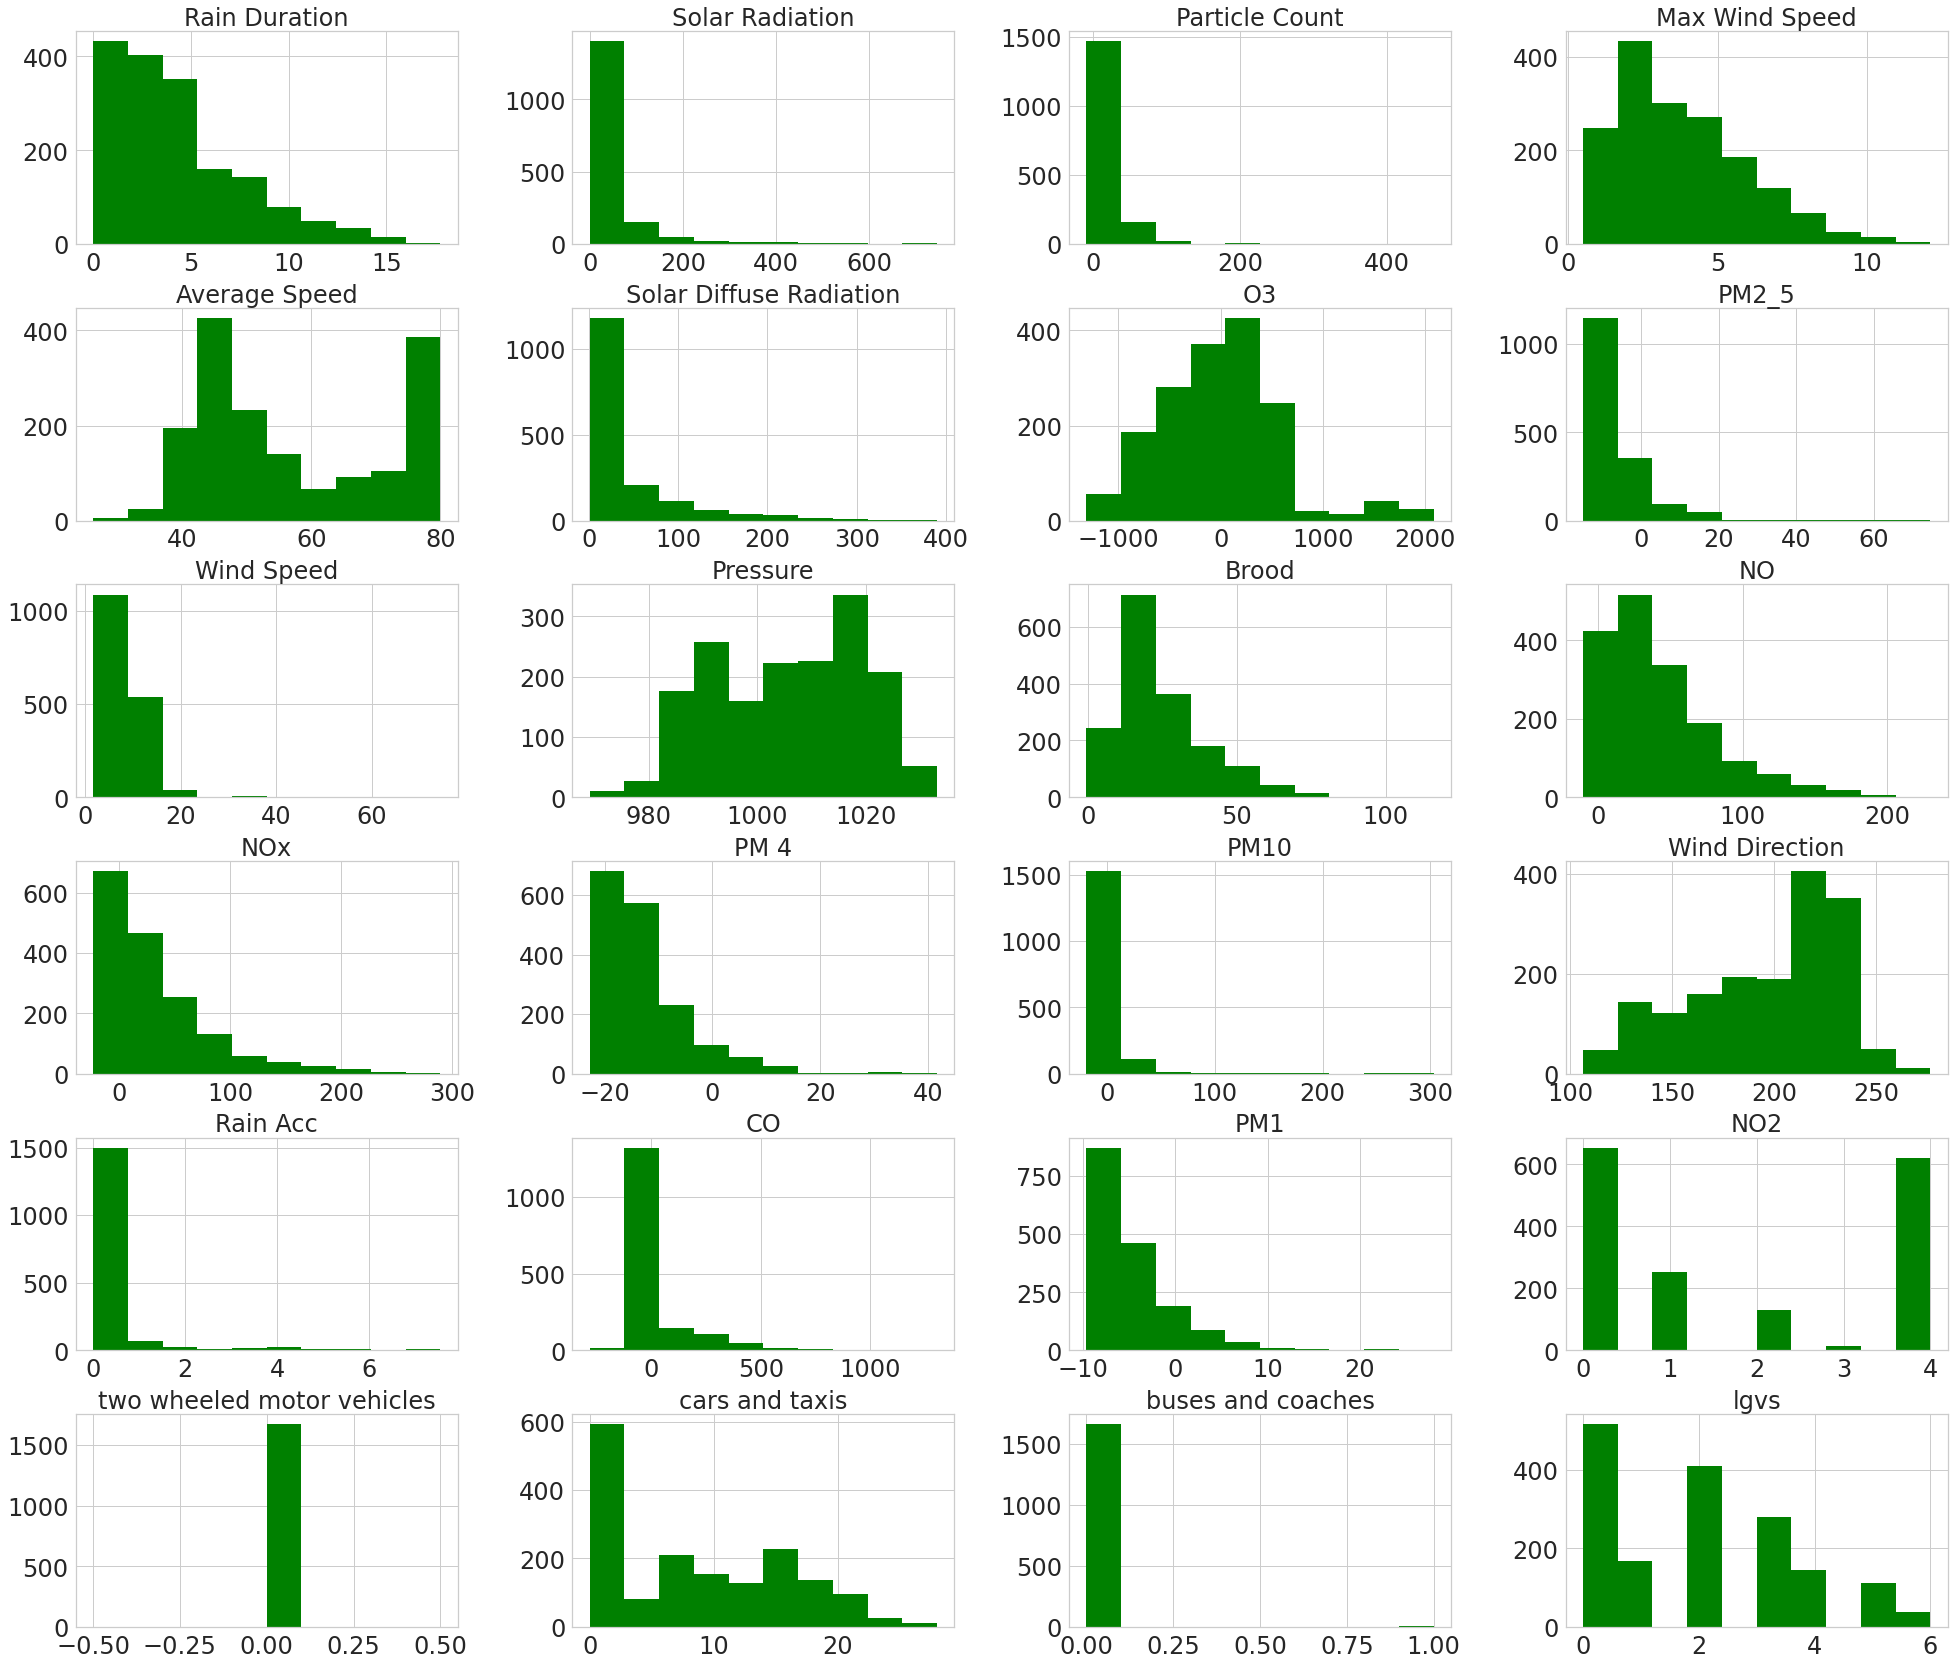

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


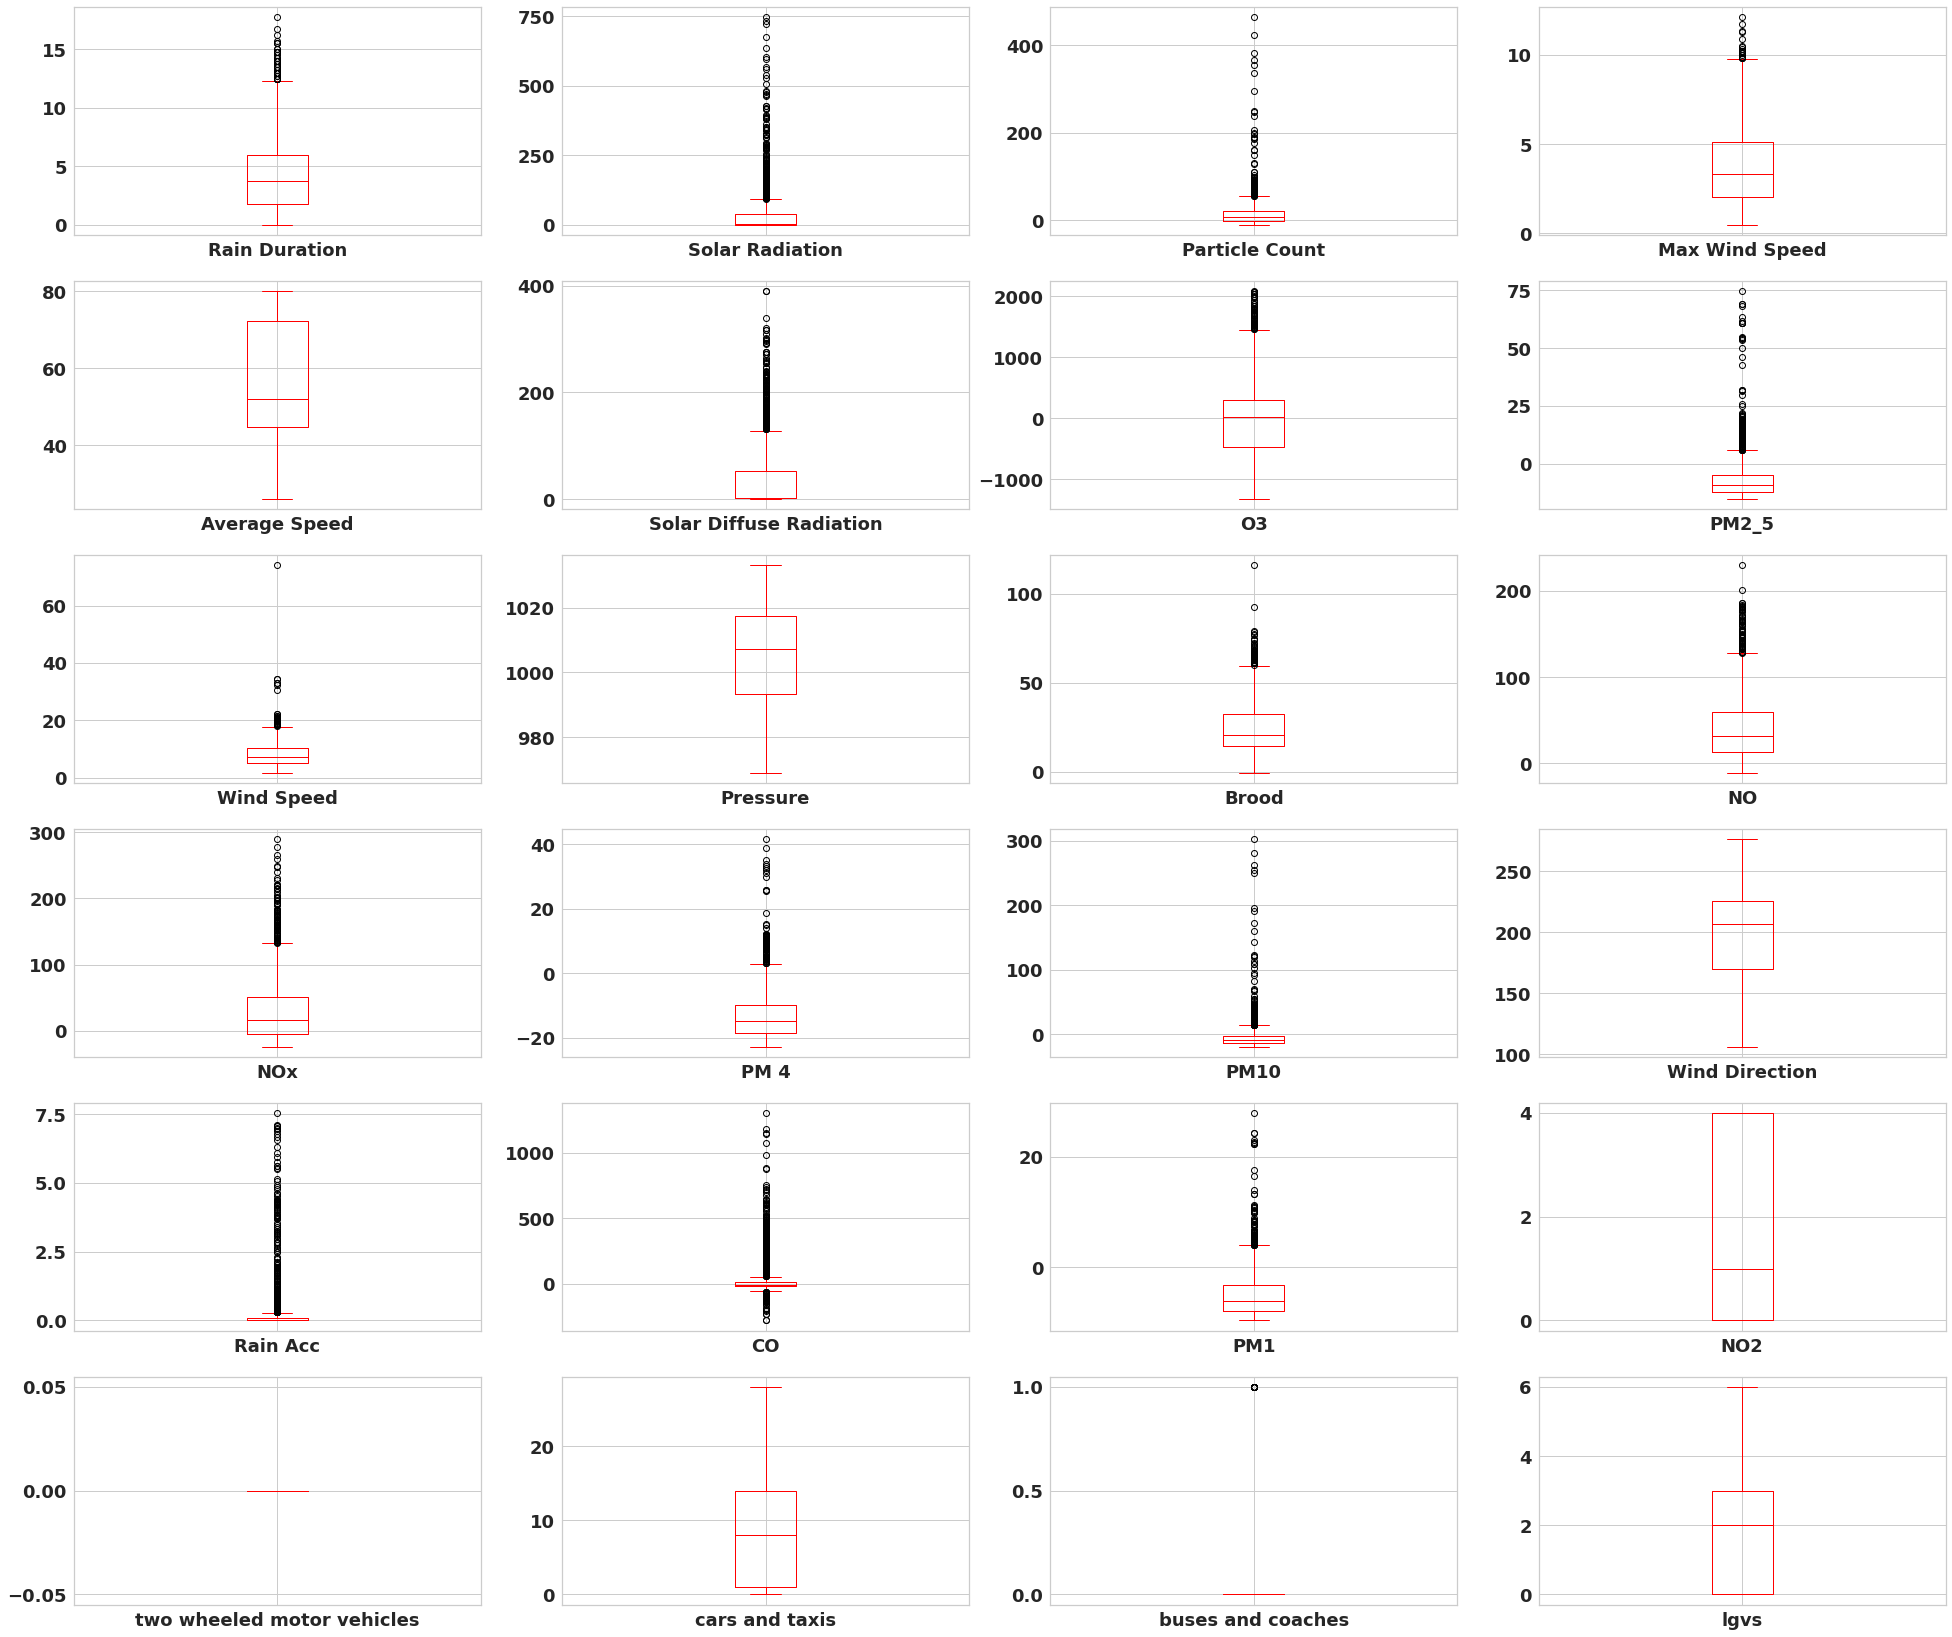

In [ ]:
DF18p.hist(figsize=(26,26), layout=(7,4), color = 'green')
plt.xticks(fontsize=40)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 40}
plt.rc('font', **font)
plt.subplots_adjust(left=4, bottom=4, right=5, top=5)
plt.xlim(xmin=0)
plt.show()



# #print quartile plot for outlier detection
DF18p.plot(kind='box', subplots=True, figsize=(26,26), layout=(7,4),
            sharex=False, sharey=False, fontsize=(18), color='red')
plt.subplots_adjust(left=4, bottom=4, right=5, top=5)
plt.show()

Epoch 1/350
1168/1168 - 4s - loss: 3.0040 - val_loss: 2.6185 - 4s/epoch - 3ms/step
Epoch 2/350
1168/1168 - 2s - loss: 2.4607 - val_loss: 2.1161 - 2s/epoch - 2ms/step
Epoch 3/350
1168/1168 - 3s - loss: 2.2041 - val_loss: 2.0783 - 3s/epoch - 2ms/step
Epoch 4/350
1168/1168 - 2s - loss: 2.0847 - val_loss: 1.9535 - 2s/epoch - 2ms/step
Epoch 5/350
1168/1168 - 2s - loss: 1.9317 - val_loss: 2.0692 - 2s/epoch - 2ms/step
Epoch 6/350
1168/1168 - 3s - loss: 1.9292 - val_loss: 1.9770 - 3s/epoch - 2ms/step
Epoch 7/350
1168/1168 - 3s - loss: 1.8295 - val_loss: 1.7452 - 3s/epoch - 2ms/step
Epoch 8/350
1168/1168 - 2s - loss: 1.8126 - val_loss: 1.7315 - 2s/epoch - 2ms/step
Epoch 9/350
1168/1168 - 2s - loss: 1.7116 - val_loss: 1.6975 - 2s/epoch - 2ms/step
Epoch 10/350
1168/1168 - 3s - loss: 1.6668 - val_loss: 1.7484 - 3s/epoch - 2ms/step
Epoch 11/350
1168/1168 - 2s - loss: 1.6337 - val_loss: 1.6719 - 2s/epoch - 2ms/step
Epoch 12/350
1168/1168 - 3s - loss: 1.5526 - val_loss: 1.9121 - 3s/epoch - 2ms/step
E

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


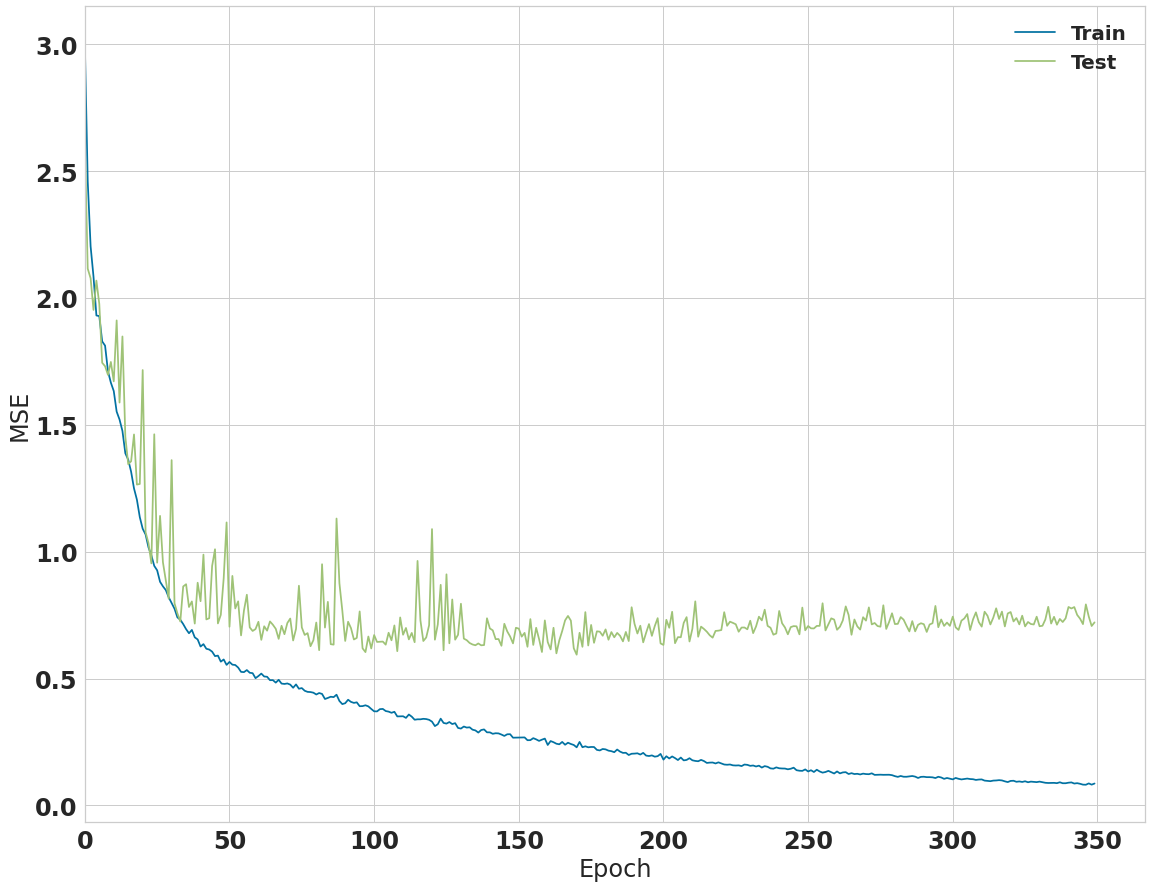

In [ ]:
#2018
model18a = Sequential()
model18a.add(LSTM(200, input_shape=(trainx18.shape[1], trainx18.shape[2])))
model18a.add(Dense(1))
model18a.compile(loss='mean_squared_error', optimizer='sgd')
# fit network
#, 
history18pos = model18a.fit(trainx18, trainlab18, epochs=350,validation_data=(testx18, testlab18), batch_size=1, verbose=2, shuffle=True)
# plot history
plt.plot(history18pos.history['loss'], label='Train')
plt.plot(history18pos.history['val_loss'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.xlim(xmin=0)
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
yhat18af = model18a.predict(testx18)

testlab18_new=testlab18.values.tolist()
print(testlab18_new)

rmse18 = np.sqrt(mean_squared_error(testlab18, yhat18af))
rmse18per = 100*rmse18/np.sqrt(np.sum(testlab18**2))

print('Test RMSE for 2018: %.3f' % rmse18)
print('Test RMSE percent for 2018: %.3f' % rmse18per)

predict_these=[2,8,10,20,30,40,50,60,70]
ys=model18a.predict(testx18[predict_these,:,:])

print("\n")
for i in range(len(predict_these)):
  print('predicted ',np.round(ys[i]),'for day',predict_these[i])



[0.0, 0.0, 0.0, 2.0, 4.0, 0.0, 0.0, 4.0, 0.0, 2.0, 4.0, 0.0, 4.0, 4.0, 4.0, 0.0, 1.0, 2.0, 2.0, 4.0, 4.0, 1.0, 1.0, 0.0, 4.0, 0.0, 4.0, 4.0, 4.0, 0.0, 4.0, 0.0, 0.0, 0.0, 4.0, 0.0, 2.0, 4.0, 4.0, 4.0, 0.0, 4.0, 1.0, 4.0, 4.0, 0.0, 3.0, 4.0, 4.0, 0.0, 0.0, 4.0, 2.0, 4.0, 0.0, 4.0, 0.0, 4.0, 4.0, 0.0, 4.0, 4.0, 0.0, 0.0, 0.0, 1.0, 4.0, 0.0, 4.0, 1.0, 0.0, 4.0, 4.0, 4.0, 1.0, 4.0, 4.0, 4.0, 0.0, 1.0, 0.0, 0.0, 0.0, 4.0, 0.0, 4.0, 4.0, 0.0, 0.0, 2.0, 4.0, 4.0, 4.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 4.0, 4.0, 4.0, 4.0, 4.0, 2.0, 4.0, 4.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 4.0, 1.0, 1.0, 4.0, 4.0, 0.0, 0.0, 1.0, 4.0, 2.0, 4.0, 4.0, 2.0, 0.0, 0.0, 1.0, 4.0, 4.0, 4.0, 1.0, 4.0, 1.0, 0.0, 0.0, 0.0, 4.0, 4.0, 4.0, 4.0, 1.0, 0.0, 0.0, 2.0, 2.0, 0.0, 4.0, 4.0, 0.0, 0.0, 4.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 4.0, 0.0, 1.0, 4.0, 0.0, 0.0, 0.0, 4.0, 1.0, 0.0, 4.0, 1.0, 0.0, 4.0, 2.0, 1.0, 0.0, 4.0, 4.0, 4.0, 4.0, 1.0, 4.0, 0.0, 4.0, 4.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 4.0, 1.0, 4.0,

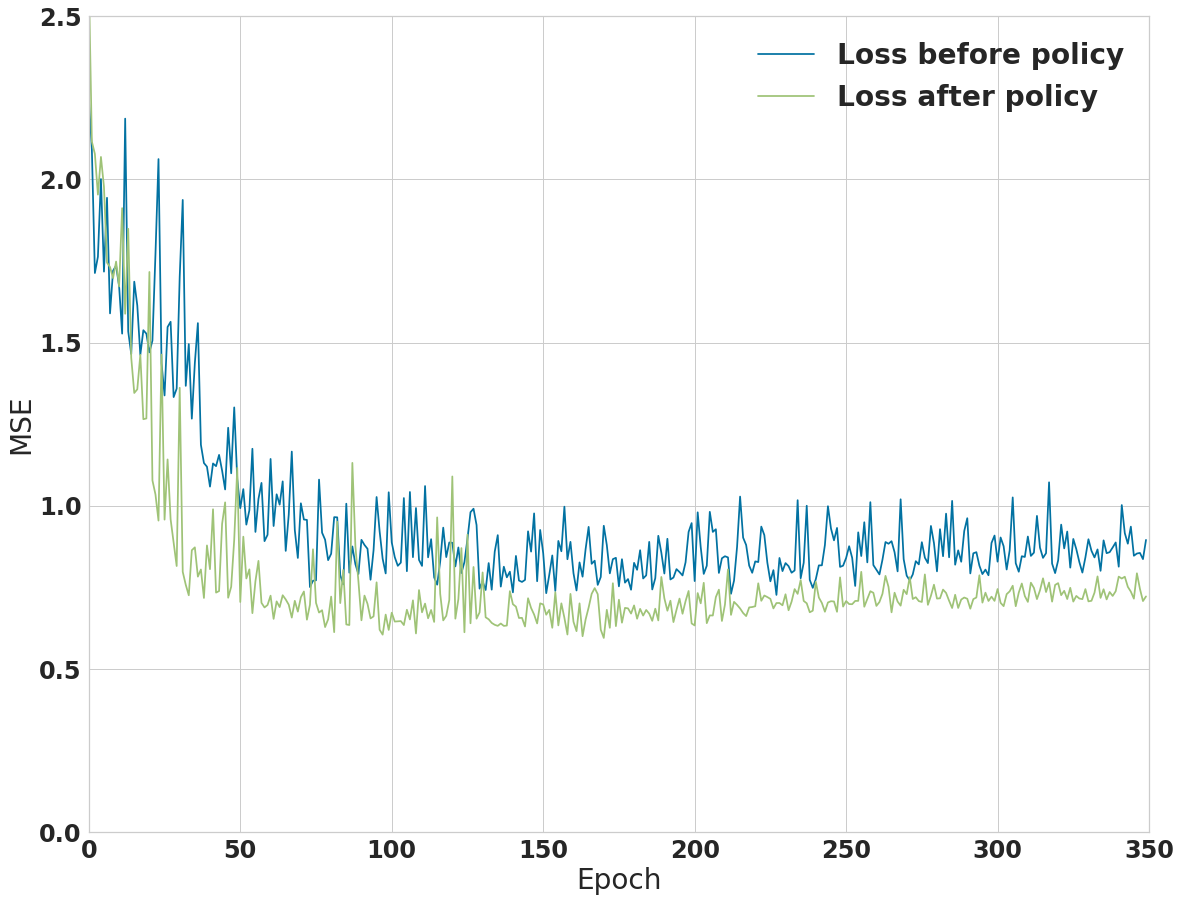

In [ ]:
plt.plot(history18pre.history['val_loss'], label='Loss before policy')
plt.plot(history18pos.history['val_loss'], label='Loss after policy')
plt.xlabel('Epoch',fontsize=28)
plt.ylabel('MSE',fontsize=28)
# plt.ylim(ymin=0,ymax=1.8)
plt.ylim(ymin=0,ymax=2.5)
plt.xlim(xmin=0,xmax=350)
plt.legend(fontsize=28)
plt.show()

No handles with labels found to put in legend.


[ 1  2  3  4 10 11 12]


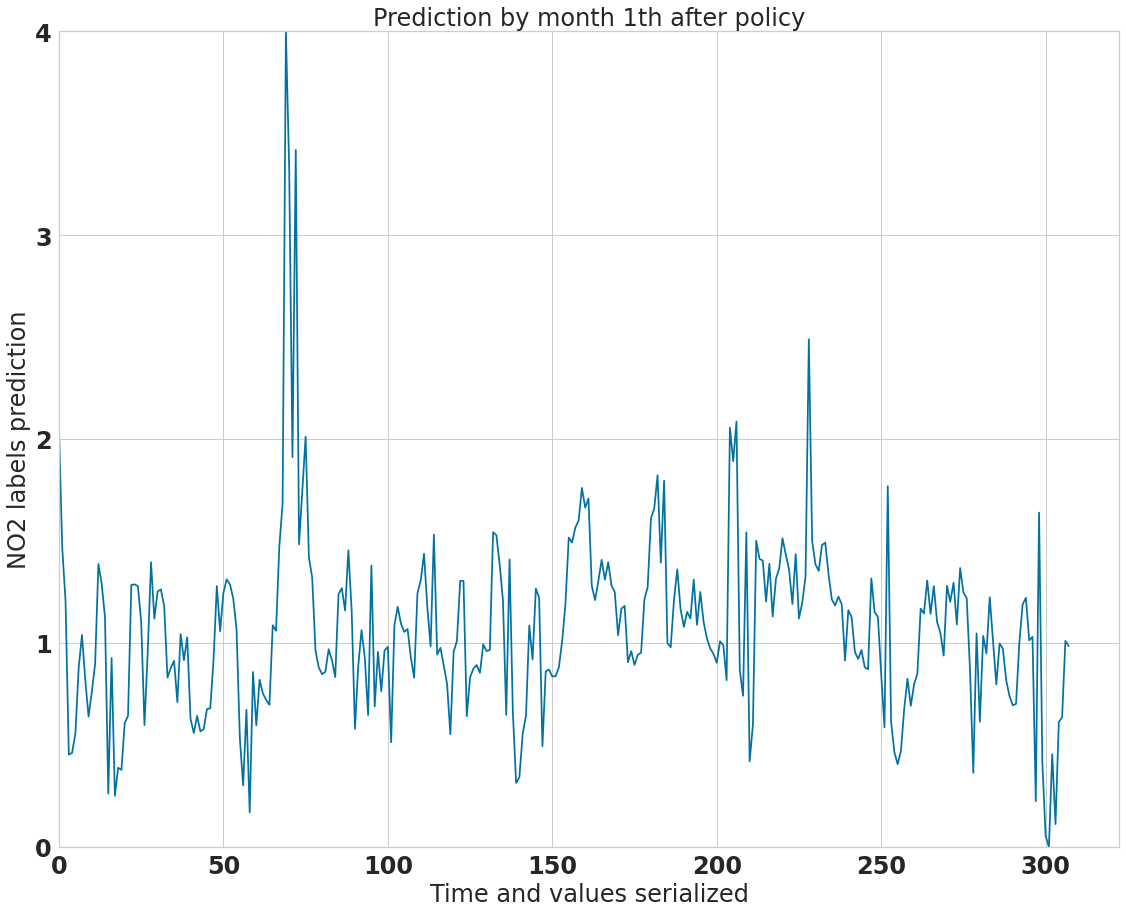

No handles with labels found to put in legend.


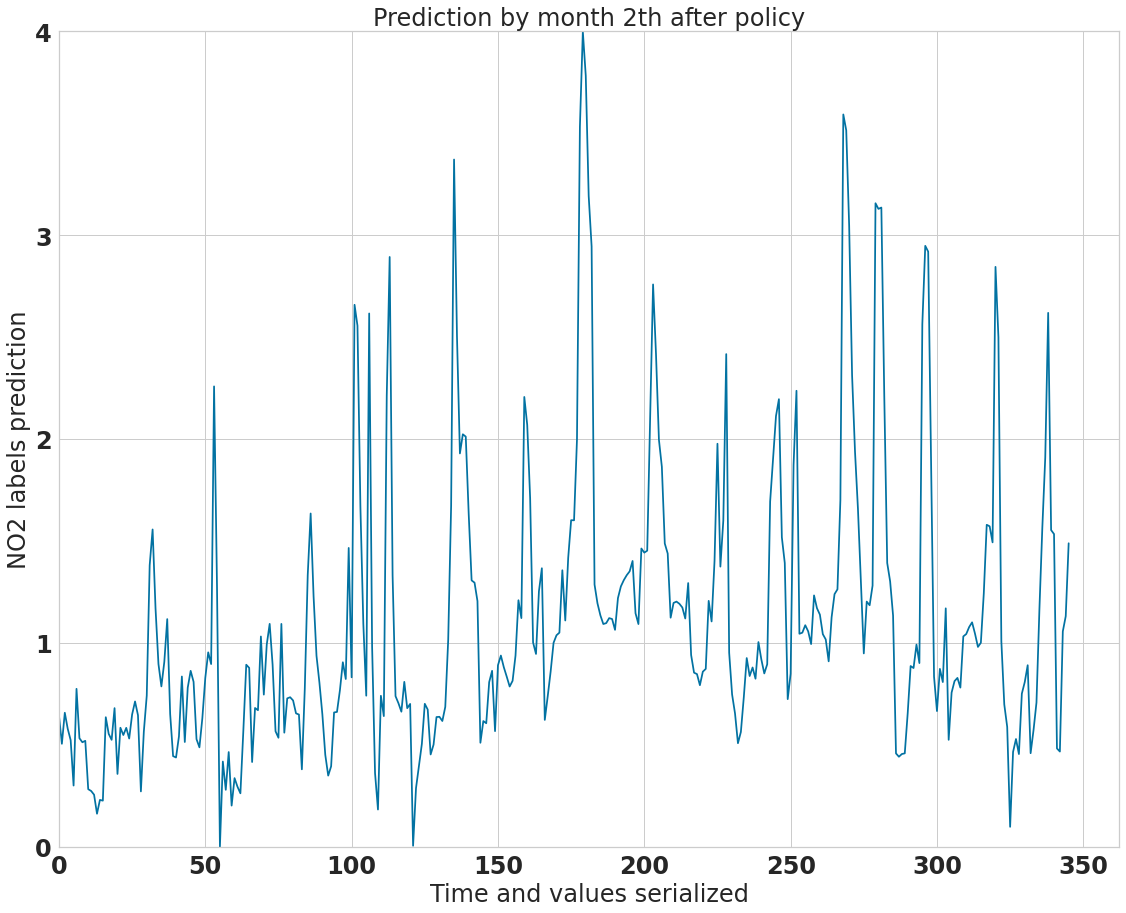

No handles with labels found to put in legend.


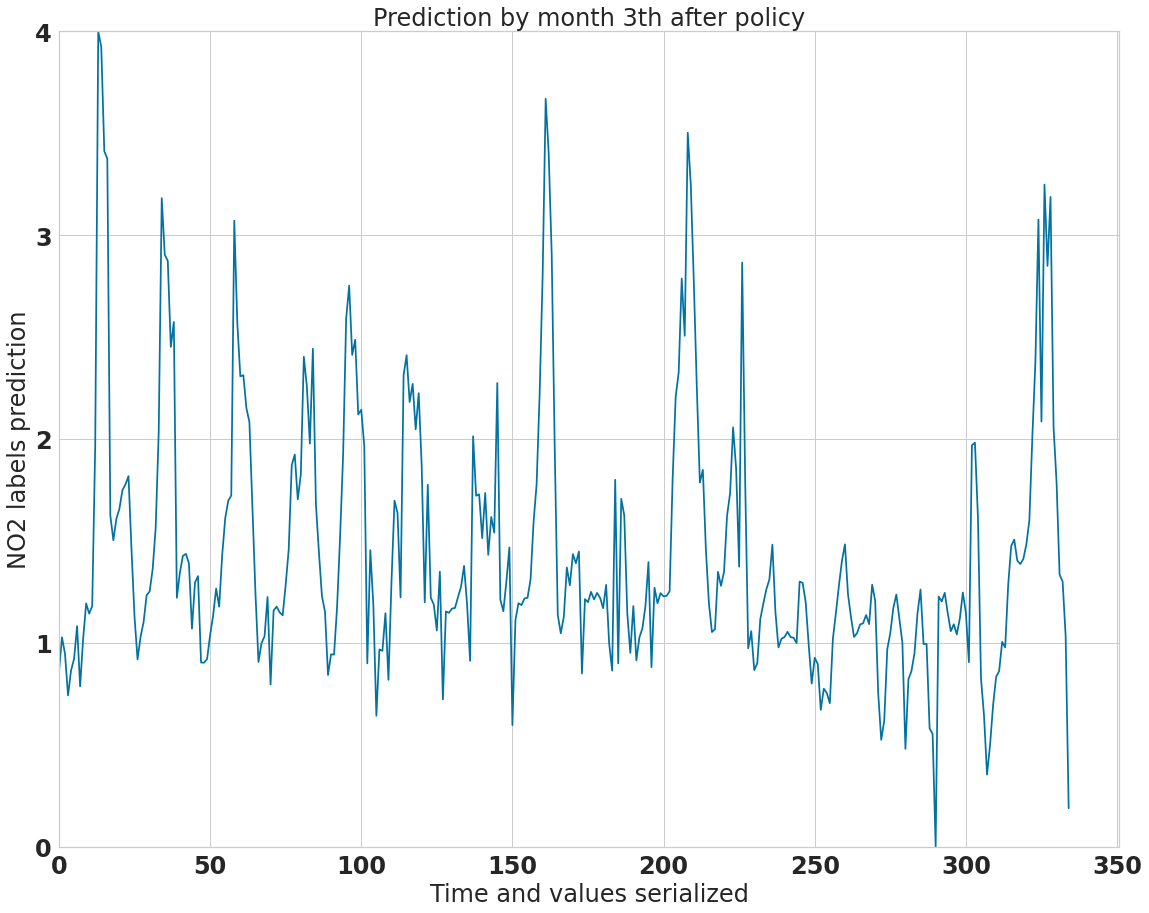

No handles with labels found to put in legend.


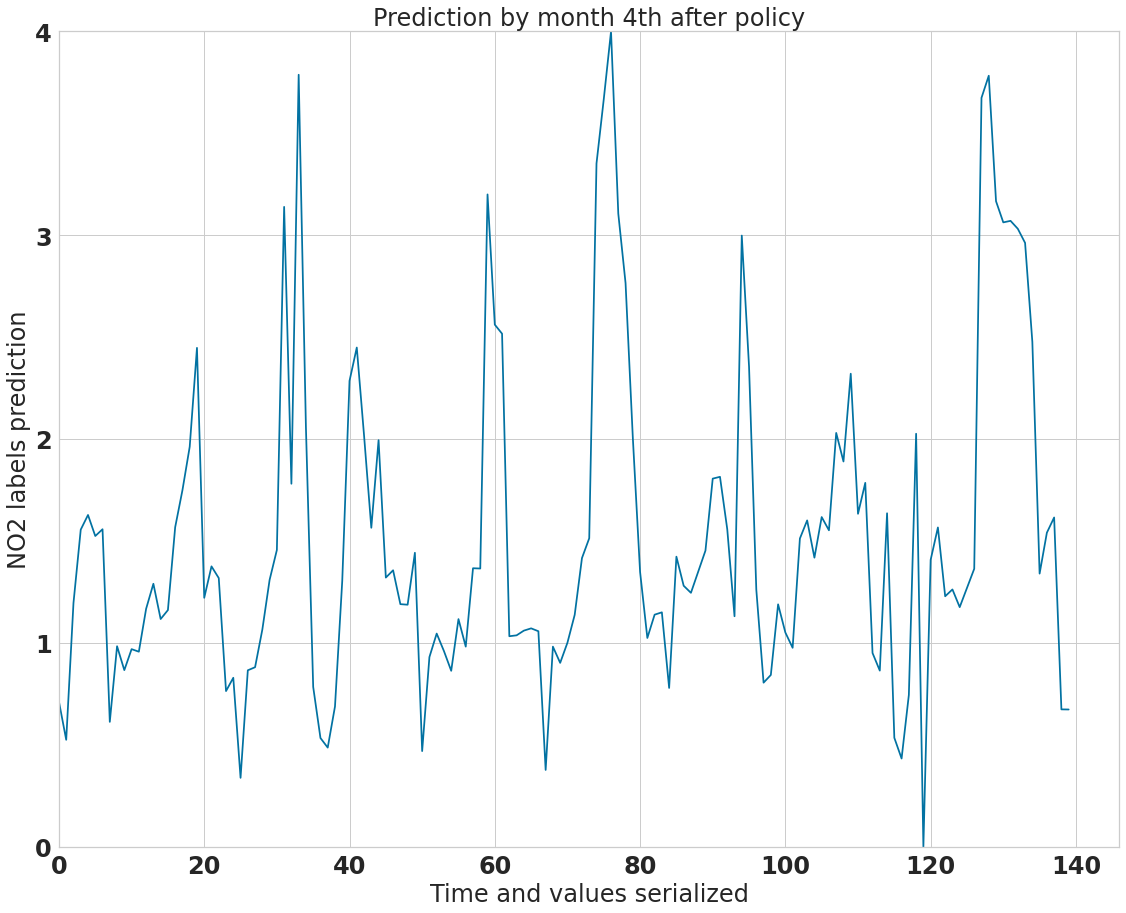

No handles with labels found to put in legend.


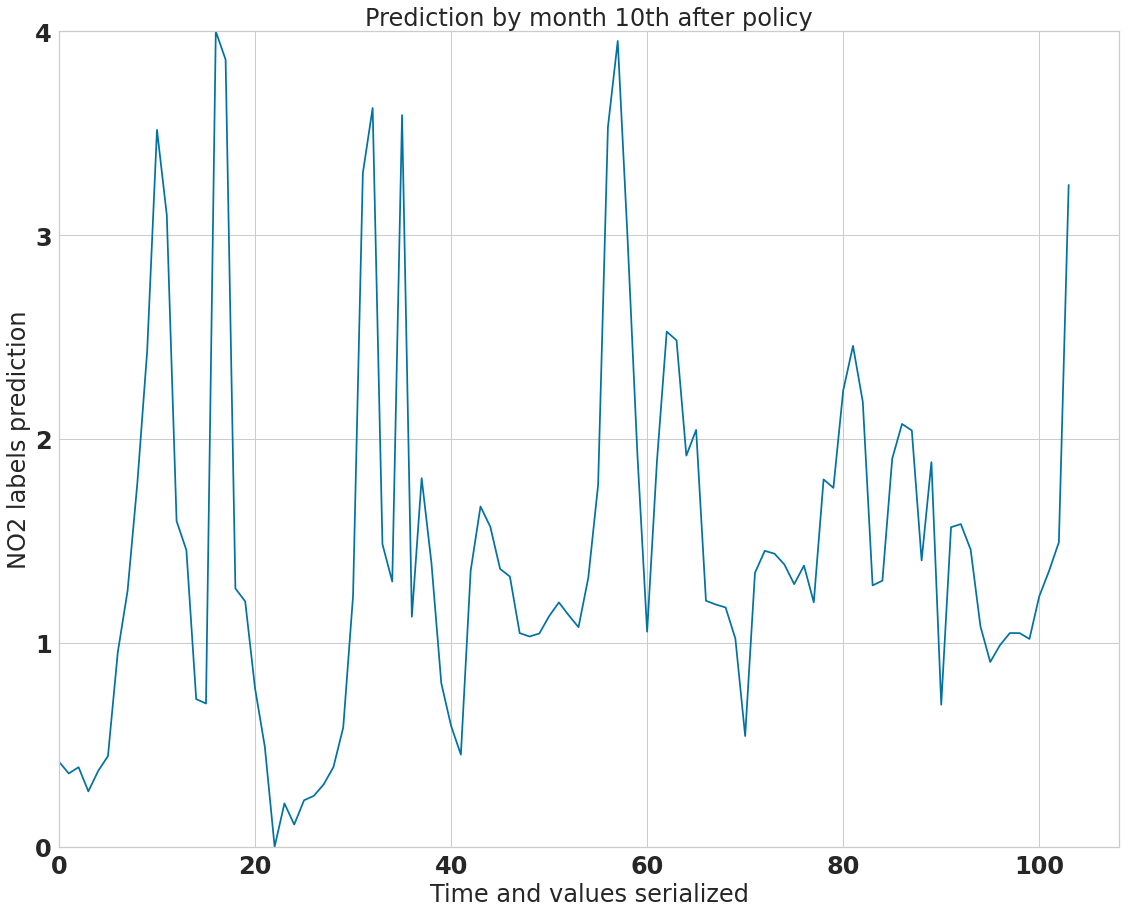

No handles with labels found to put in legend.


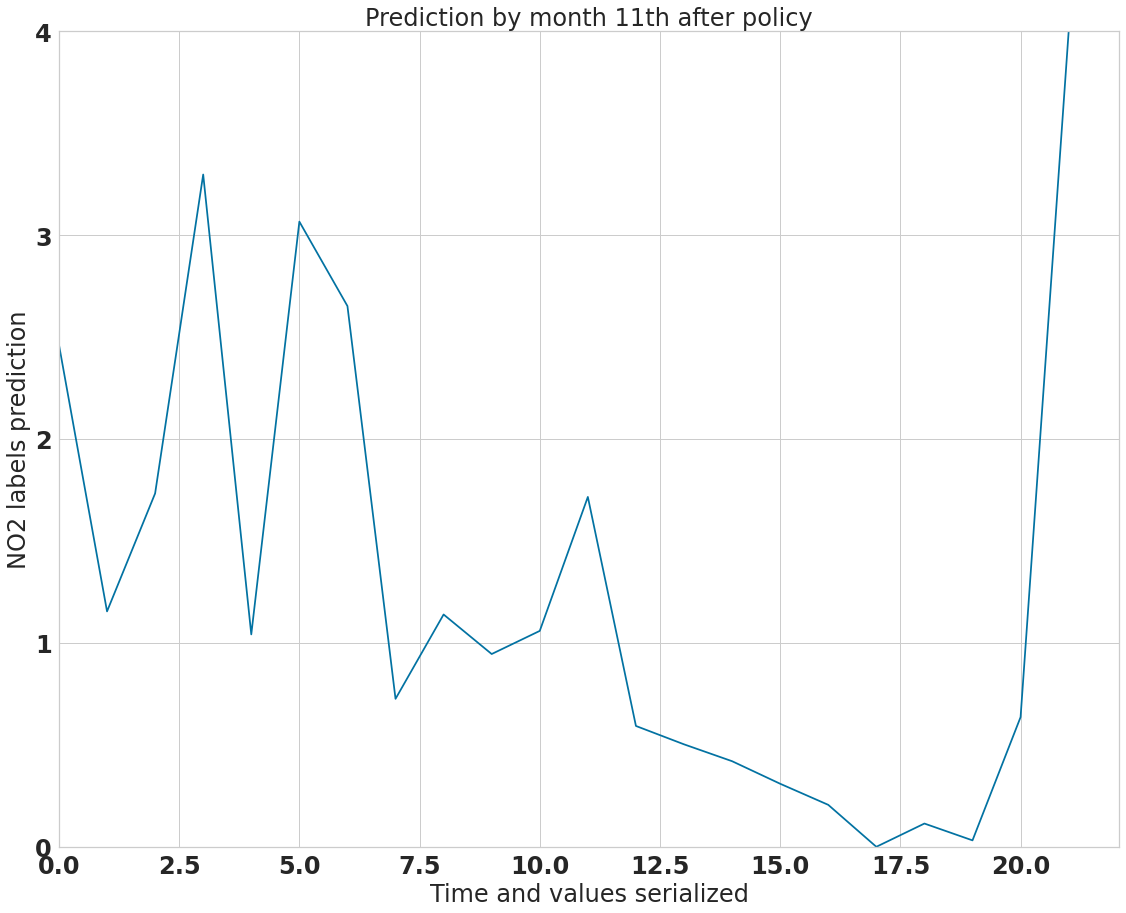

No handles with labels found to put in legend.


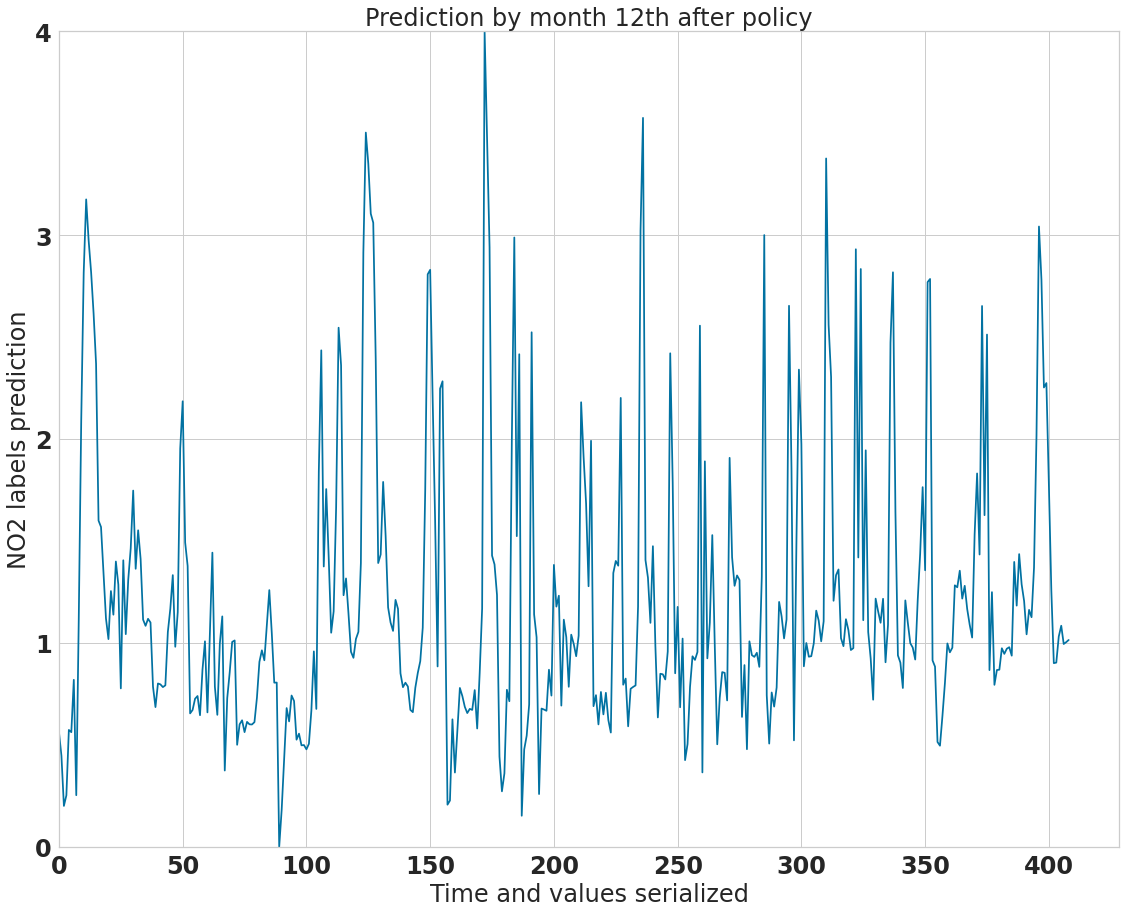

In [ ]:
DF18=pd.read_csv('mix2018.csv')
monthvals=DF18.month.unique()


tf=DF18['Traffic Flow'].values
twmv=np.round(tf* 0.0063)
cat=np.round(tf*0.8)
bac=np.round(tf*0.0124)
lgvs=np.round(tf*0.1813)
DF18['two wheeled motor vehicles']=twmv
DF18['cars and taxis']=cat
DF18['buses and coaches']=bac
DF18['lgvs']=lgvs

# 18
twmv18=DF18["two wheeled motor vehicles"].values
twmv18=np.round(twmv18*0.8)
cat18=DF18["cars and taxis"].values
cat18=np.round(cat18*0.8)
bac18=DF18["buses and coaches"].values
bac18=np.round(bac18*0.9)
lgvs18=DF18["lgvs"].values
lgvs18=np.round(lgvs18*0.8)
co18=DF18["CO"].values
co18=co18-18
pm2518=DF18["PM2_5"].values
pm2518=pm2518 -16
par18=DF18["Particle Count"].values
par18=par18 -10
pm118=DF18["PM1"].values
pm118=pm118 -10
pm1018=DF18["PM10"].values
pm1018=pm1018 -21
pm418=DF18["PM 4"].values
pm418=pm418 -23
o318=DF18["O3"].values
o318=o318 -29
no18=DF18["NO"].values
no18=no18 -18
nox18=DF18["NOx"].values
nox18=nox18 -24
no218=DF18["NO2"].values
no218=no218 -25


DF18["two wheeled motor vehicles"]=twmv18
DF18["cars and taxis"]=cat18
DF18["buses and coaches"]=bac18
DF18["lgvs"]=lgvs18
DF18["CO"]=co18
DF18["PM2_5"]=pm2518
DF18["Particle Count"]=par18
DF18["PM1"]=pm118
DF18["PM10"]=pm1018
DF18["PM 4"]=pm418
DF18["O3"]=o318
DF18["NO"]=no18
DF18["NOx"]=nox18
DF18["NO2"]=no218

labels2018=DF18['NO2']
templ2018=set_tags_no2(labels2018)
DF18.NO2=templ2018
Ys=DF18["NO2"].values
Ys_of_train=np.zeros_like(Ys)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4

DF18.NO2=Ys_of_train


print(monthvals)
for j in monthvals:

  tempdf=DF18.loc[DF18['month'] == j]
  trainx18=tempdf.drop('NO2', axis=1)
  
  scaler = MinMaxScaler(feature_range=(0, 1))
  values18 = scaler.fit_transform(trainx18)
  trainx18 = series_to_supervised(values18, 1, 1)
  trainlab18=tempdf['NO2'].values

  trainx18=trainx18.values
  trainlab18=trainlab18[:52]
  trainx18 = trainx18.reshape((trainx18.shape[0], 1, trainx18.shape[1]))
  trainx18 =trainx18[:,:,:52]
  yhats = model18a.predict(trainx18)
  scaler = MinMaxScaler(feature_range=(0, 4))
  yhats = scaler.fit_transform(yhats)
  plt.plot(yhats)
  plt.xlabel('Time and values serialized')
  plt.ylabel('NO2 labels prediction')
  plt.title('Prediction by month '+str(j)+'th after policy')
  plt.yticks([0,1,2,3,4])
  plt.ylim(ymin=0,ymax=4)
  plt.xlim(xmin=0)
  plt.legend()
  plt.show()


#datagraphy beforeand after policy

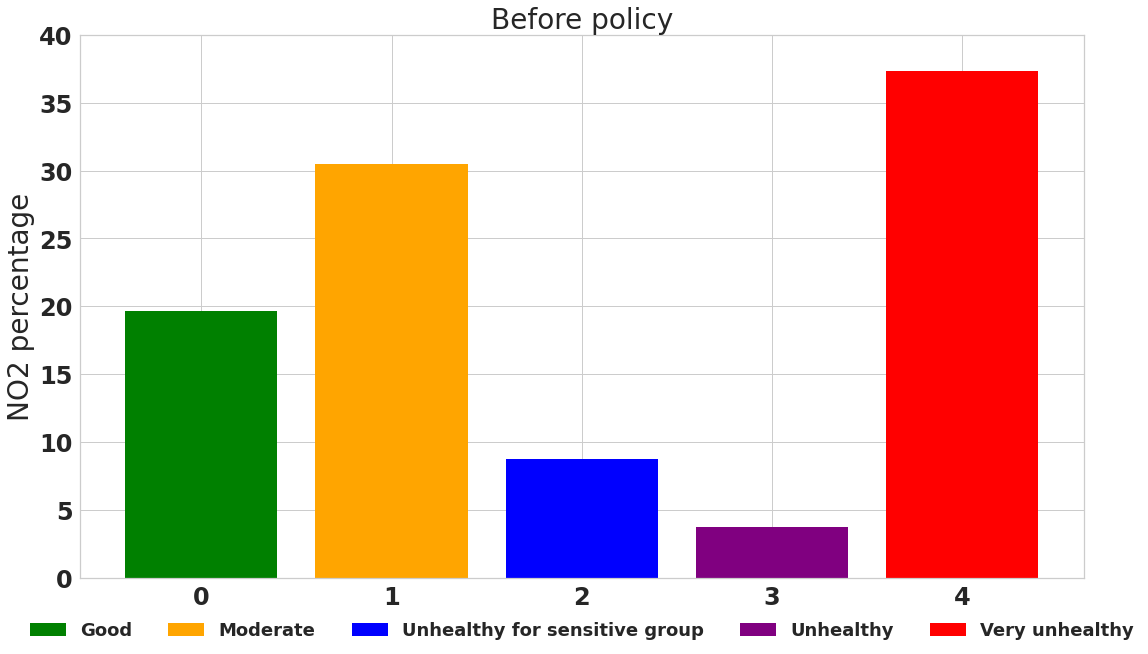

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


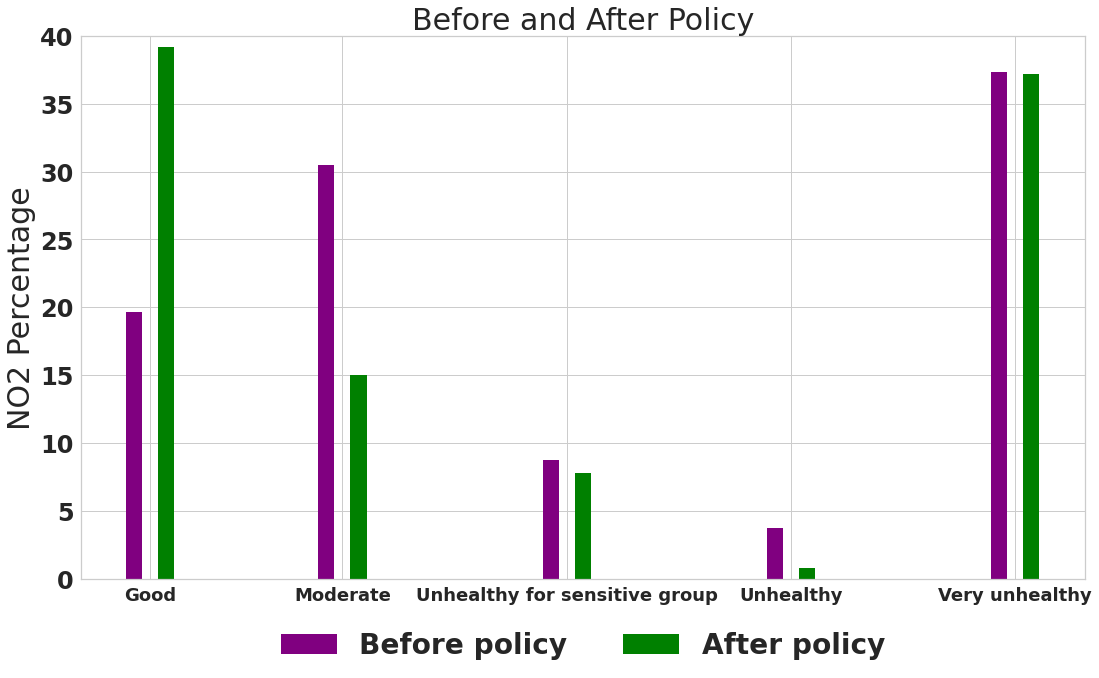

In [ ]:

DF2018=pd.read_csv('mix2018.csv')

# print(DF2019.head())
DF2018.reset_index(drop=True, inplace=True)

labels2018=DF2018['NO2']
templ2018=set_tags_no2(labels2018)
DF2018.NO2=templ2018


Ys=DF2018["NO2"].values
Ys_of_train=np.zeros_like(Ys)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4

B418=Ys_of_train

color=['green','orange','blue','purple','red']
labels=['Good','Moderate','Unhealthy for sensitive group','Unhealthy','Very unhealthy']
fig, ax = plt.subplots(1,1, figsize=(18,10))

hist, bins = np.histogram(B418,bins=5,density=True)
hist=hist/hist.sum()
for w,x,y,z in zip(np.ceil(bins[:-1]), hist.astype(np.float32)*100, color, labels):
    ax.bar(w,x, color = y, width=(bins[1]-bins[0]), label = z)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5,fontsize=18)
ax.set_ylim(ymin=0,ymax=40)
ax.set_title('Before policy',fontsize=28)
ax.set_ylabel('NO2 percentage',fontsize=28)

fig, ax = plt.subplots(1,1, figsize=(18,10))

hist, bins = np.histogram(Af18,bins=5,density=True)
hist=hist/hist.sum()
for w,x,y,z in zip(np.ceil(bins[:-1]), hist.astype(np.float32)*100, color, labels):
    ax.bar(w,x, color = y, width=(bins[1]-bins[0]), label = z)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5,fontsize=10)
ax.set_ylim(ymin=0,ymax=40)
ax.set_title('After policy',fontsize=28)
ax.set_ylabel('NO2 percentage',fontsize=28)











xaxis = [3,9,16,23,30]
xaxis_dec = [x-0.5 for x in xaxis]
xaxis_inc = [x+0.5 for x in xaxis]
color=['green','orange','blue','purple','red']
labels=['Good','Moderate','Unhealthy for sensitive group','Unhealthy','Very unhealthy']



hist, bins = np.histogram(B418,bins=5,density=True)
hist=hist/hist.sum()
hist2, bins2 = np.histogram(Af18,bins=5,density=True)
hist2=hist2/hist2.sum()



rec0 = [hist[0].astype(np.float32)*100,hist[1].astype(np.float32)*100,hist[2].astype(np.float32)*100,hist[3].astype(np.float32)*100,hist[4].astype(np.float32)*100]
rec1 = [hist2[0].astype(np.float32)*100,hist2[1].astype(np.float32)*100,hist2[2].astype(np.float32)*100,hist2[3].astype(np.float32)*100,hist2[4].astype(np.float32)*100]

ax = plt.subplot(111)
ax.bar(xaxis_dec, rec0, width=0.5,color='purple',align='center', label = 'Before policy')
ax.bar(xaxis_inc, rec1, width=0.5,color='green',align='center', label = 'After policy')

ax.set_ylim((0, 40))
plt.xticks(xaxis, labels, fontsize=18)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5,fontsize=28)
plt.ylabel('NO2 Percentage', fontsize=30)
plt.title("Before and After Policy", fontsize=30)
plt.show()


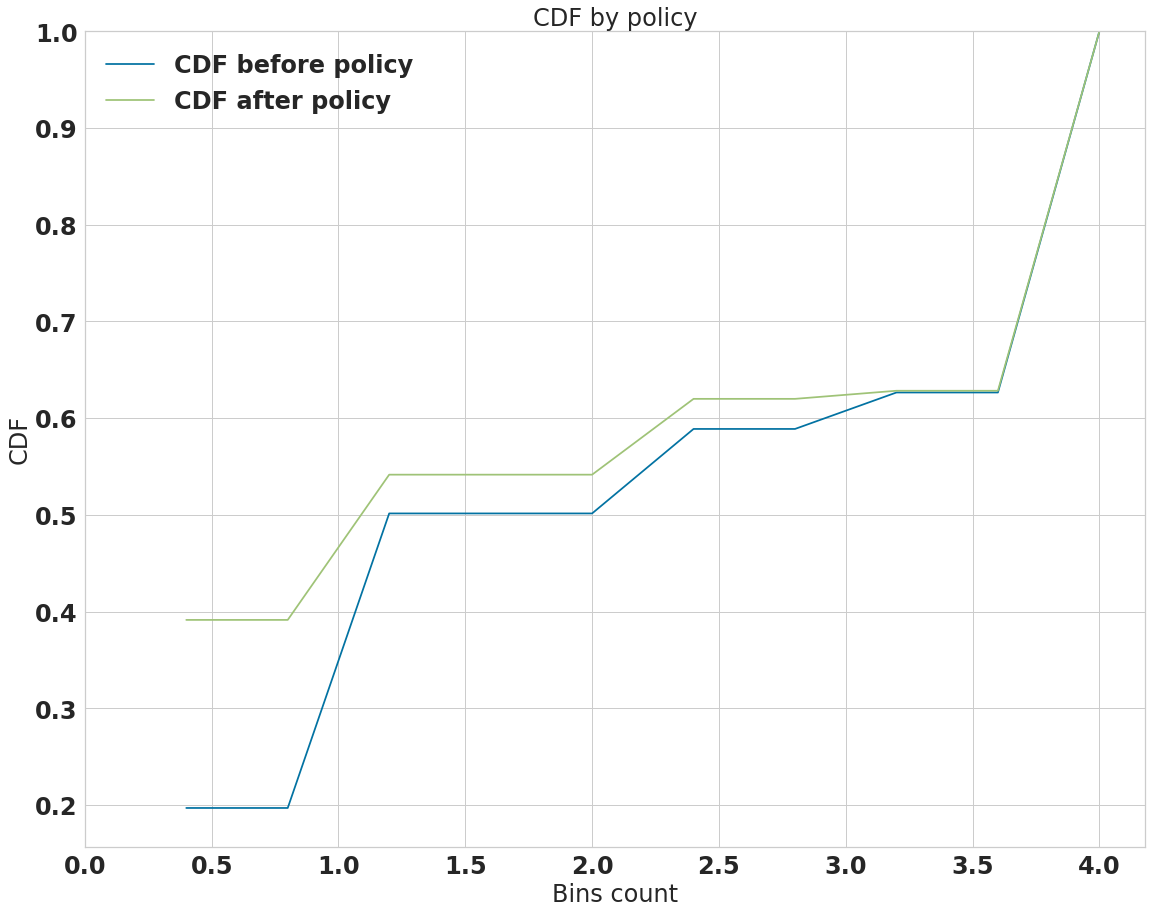

In [ ]:
count, bins_count = np.histogram(B418, bins=10)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="CDF before policy")
plt.legend(fontsize=28)
plt.xlabel('Bins count',fontsize=24)
plt.ylabel('CDF',fontsize=24)
plt.title('CDF by policy',fontsize=24)

count, bins_count = np.histogram(Af18, bins=10)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="CDF after policy")
plt.ylim(ymax=1.0)
plt.xlim(xmin=0)
plt.legend(fontsize=24)

plt.show()


No handles with labels found to put in legend.
No handles with labels found to put in legend.


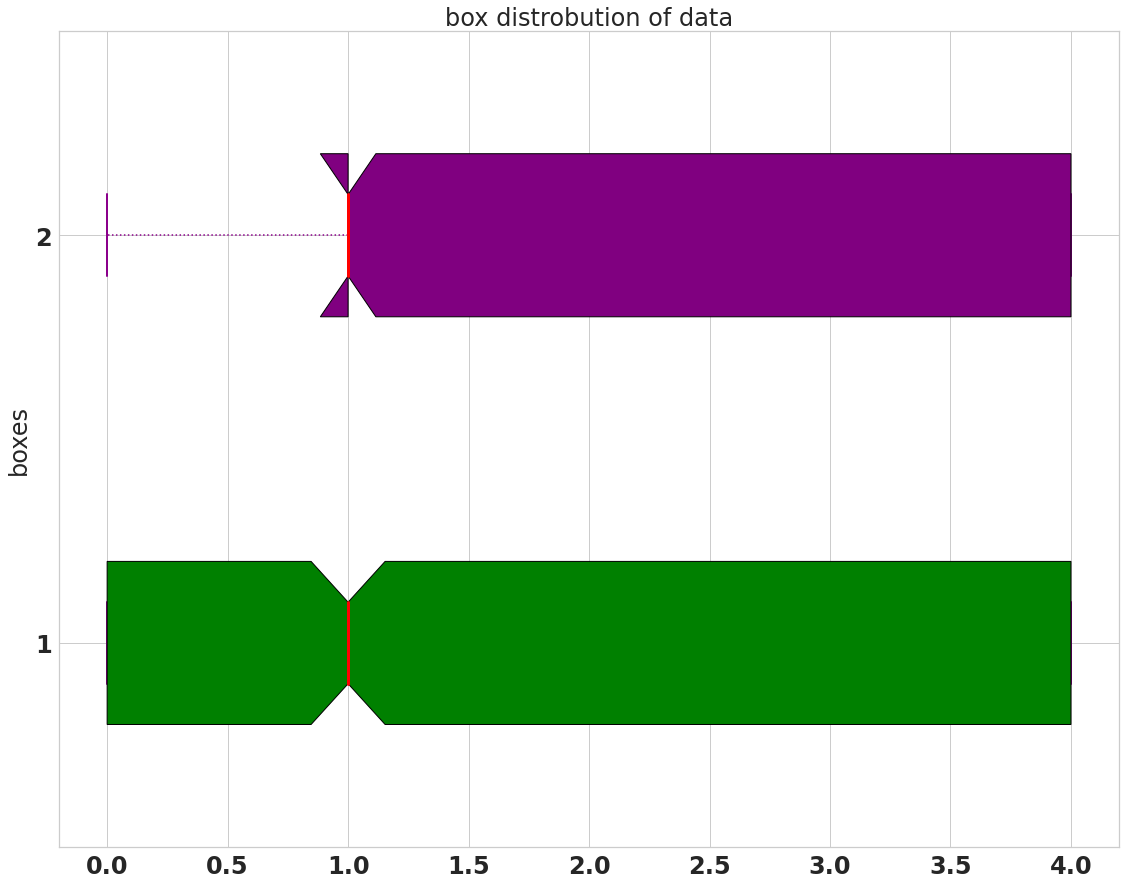

In [ ]:
 
colors = ['purple']
 
data=B418

bp=plt.boxplot(data, patch_artist = True,positions=[2],
                notch ='True', vert = 0,widths=0.4)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)

for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)

for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)

plt.legend()

colors = ['green']
data=Af18

bp=plt.boxplot(data, patch_artist = True,positions=[1],
                notch ='True', vert = 0,widths=0.4)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)

for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)

for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
plt.legend()
plt.ylabel('boxes')
plt.title('box distrobution of data')
plt.show()

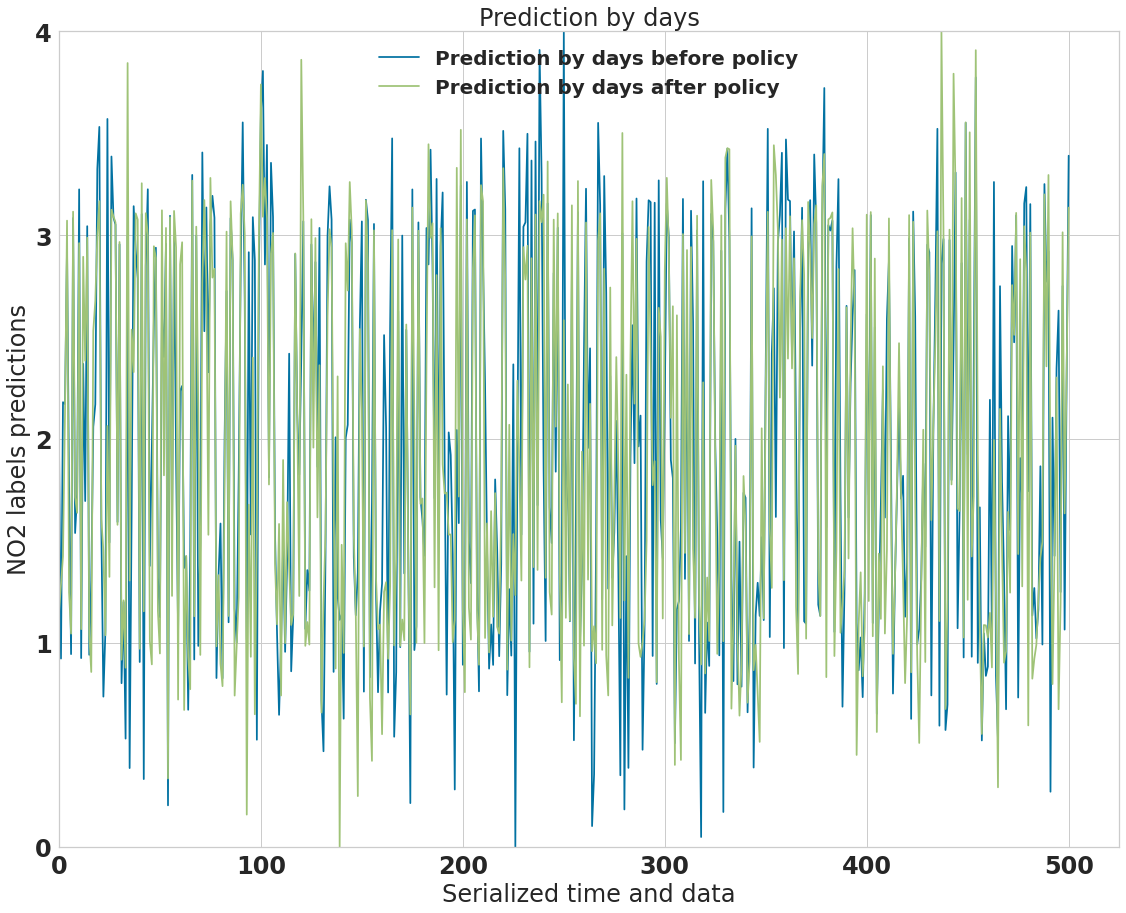

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 4))
yhat18 = scaler.fit_transform(yhat18)
yhat18af = scaler.fit_transform(yhat18af)
plt.plot(yhat18, label='Prediction by days before policy')
plt.plot(yhat18af, label='Prediction by days after policy')
plt.ylabel('NO2 labels predictions')
plt.yticks([0,1,2,3,4])
plt.xlabel('Serialized time and data')
plt.title('Prediction by days')
plt.ylim(ymin=0, ymax=4)
plt.xlim(xmin=0)
plt.legend()
plt.show()

[ 1  2  3  4 10 11 12]


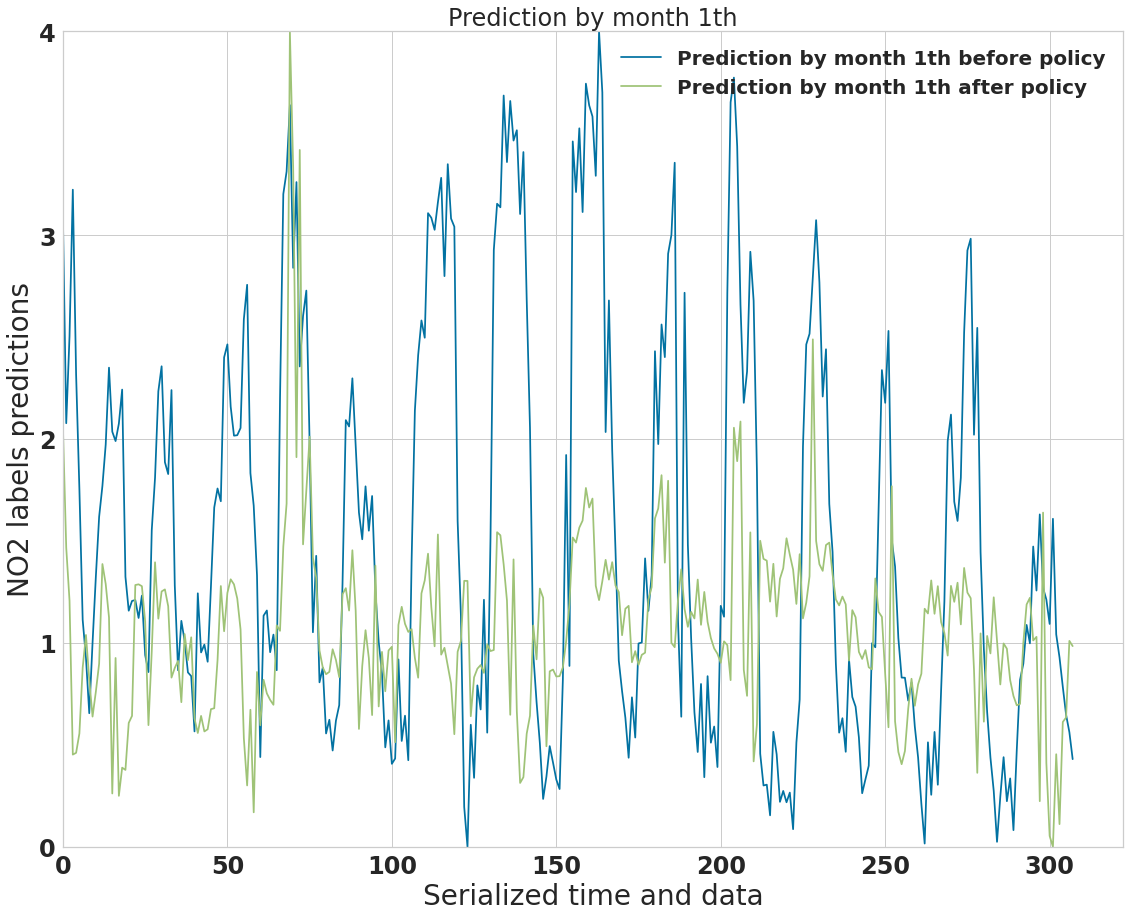

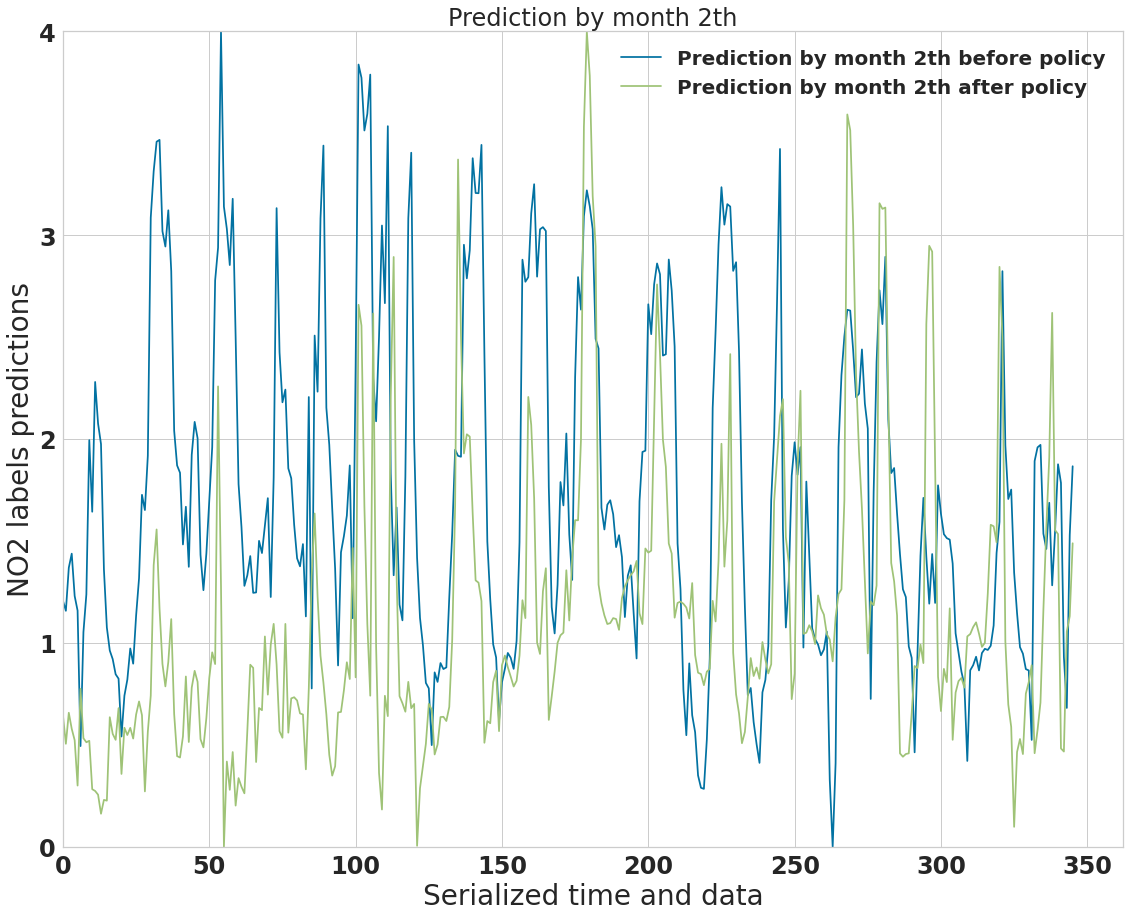

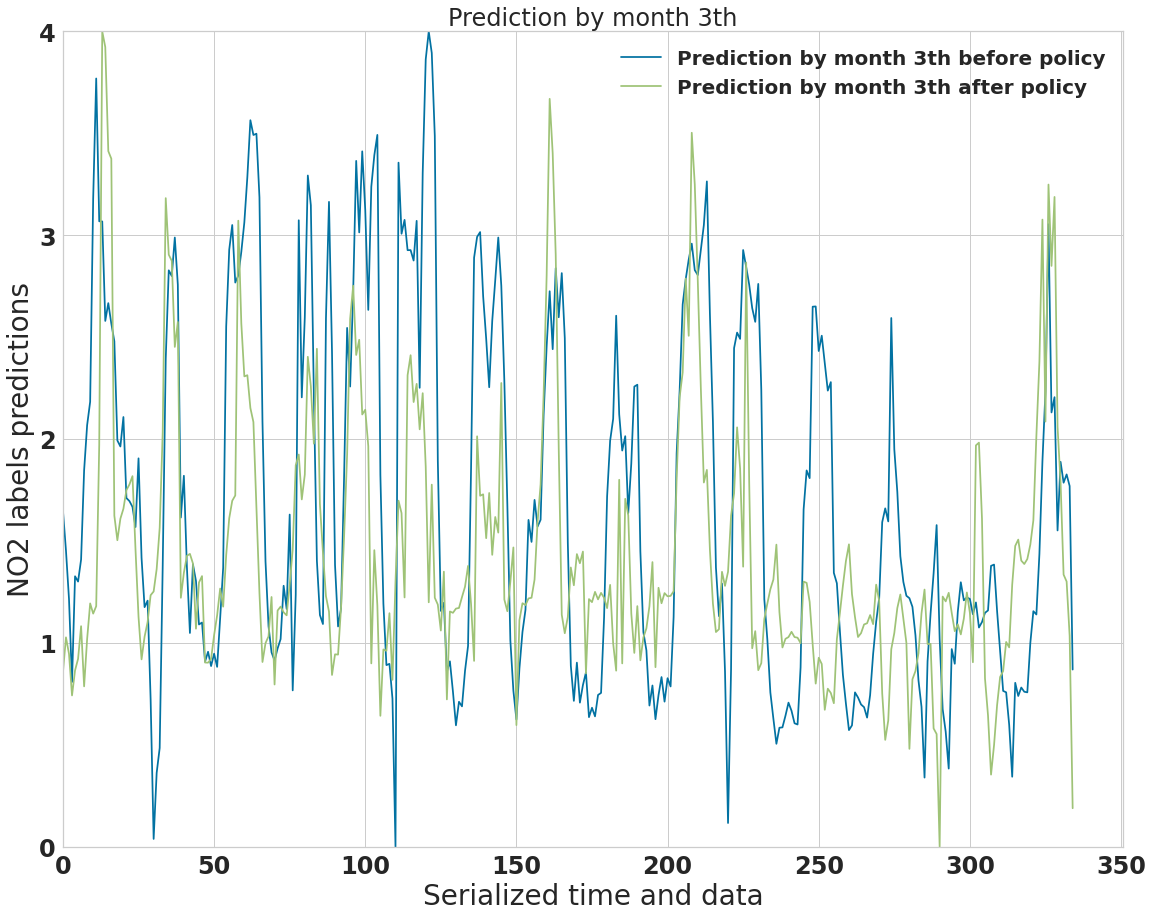

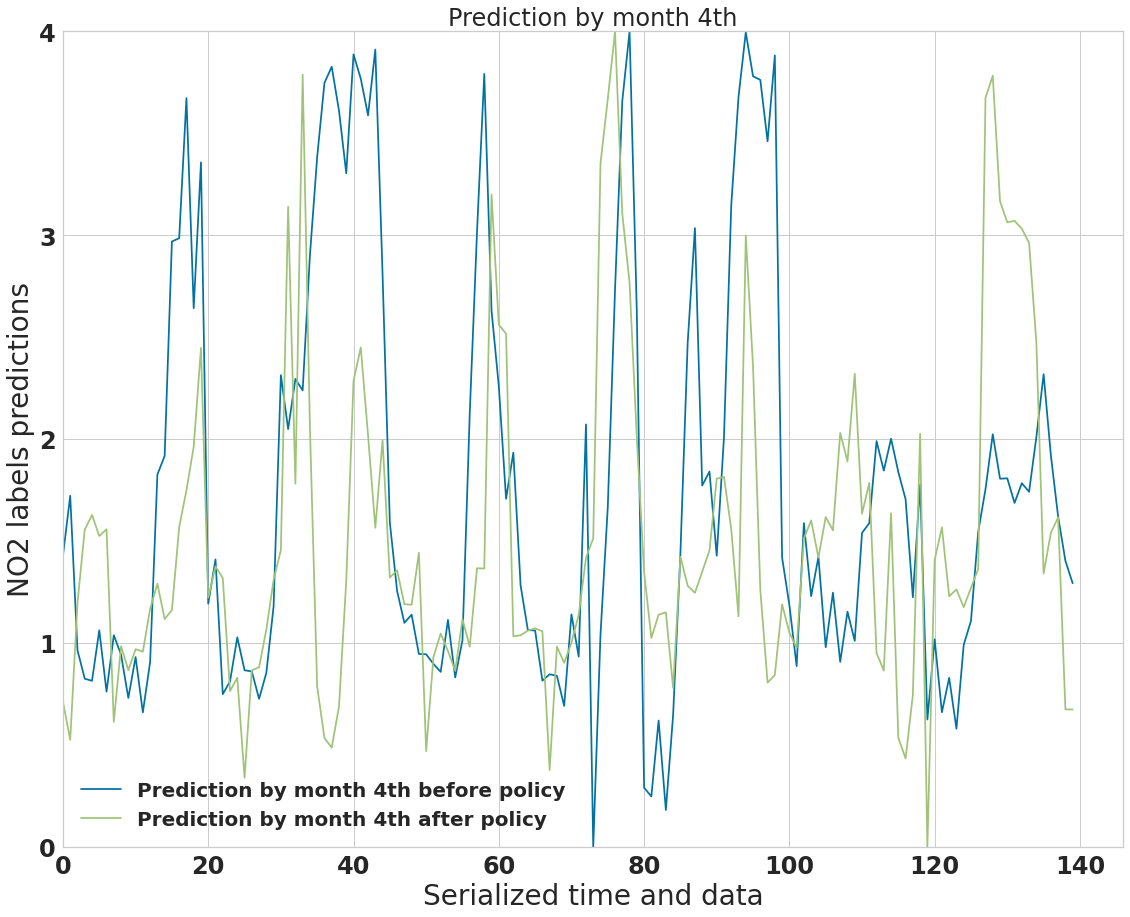

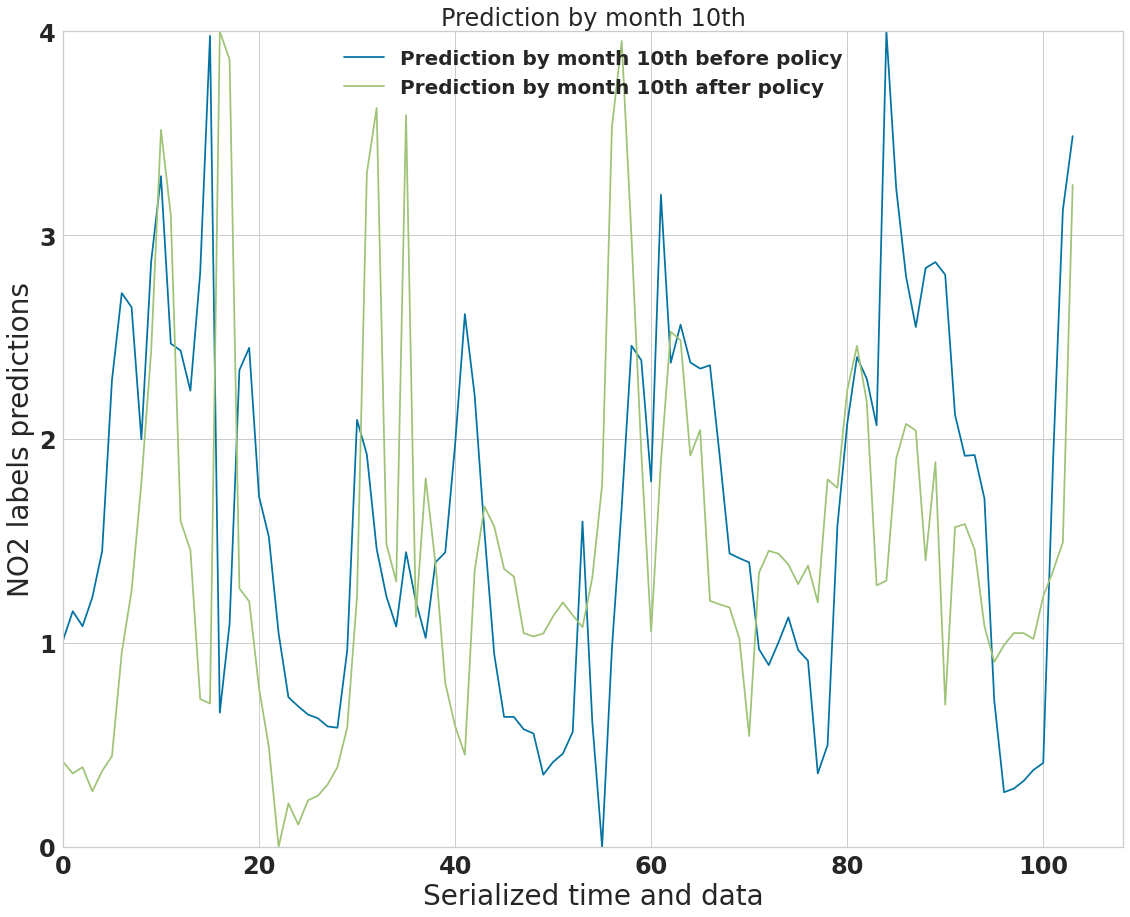

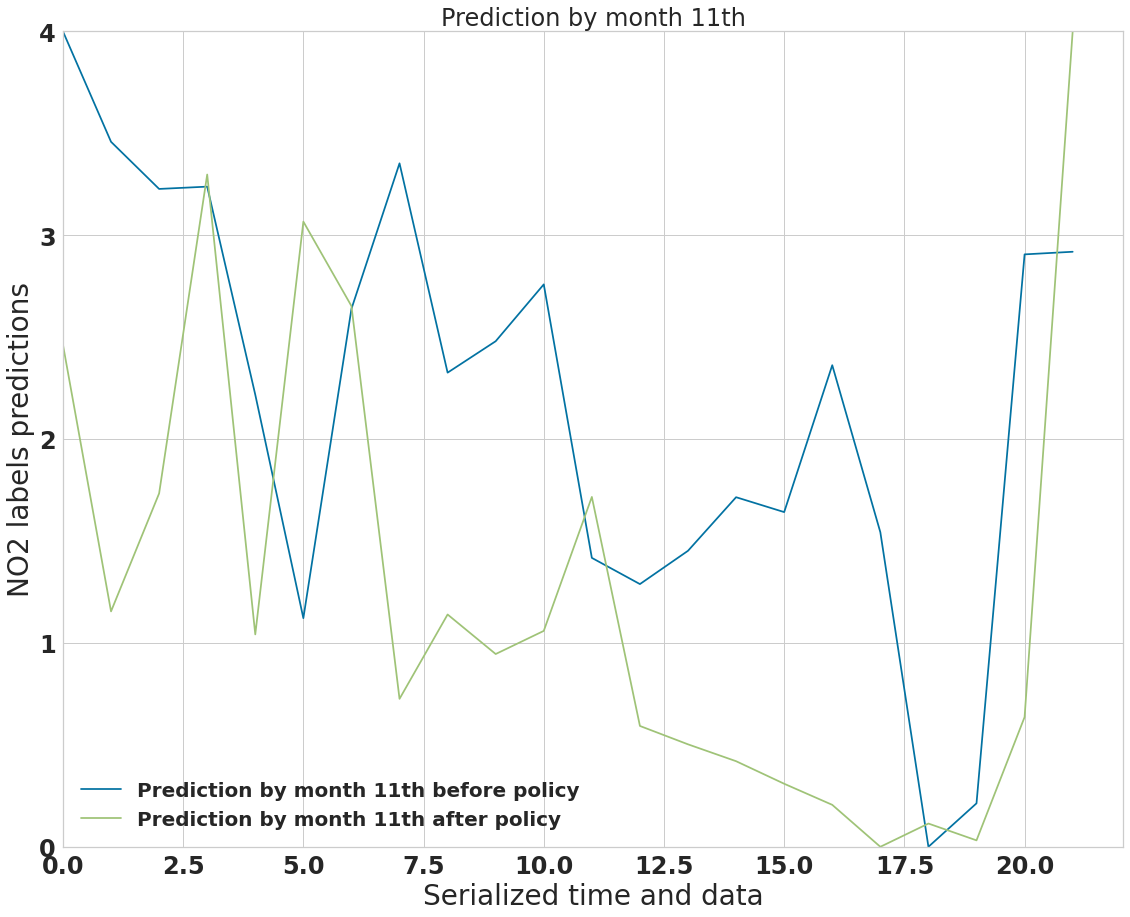

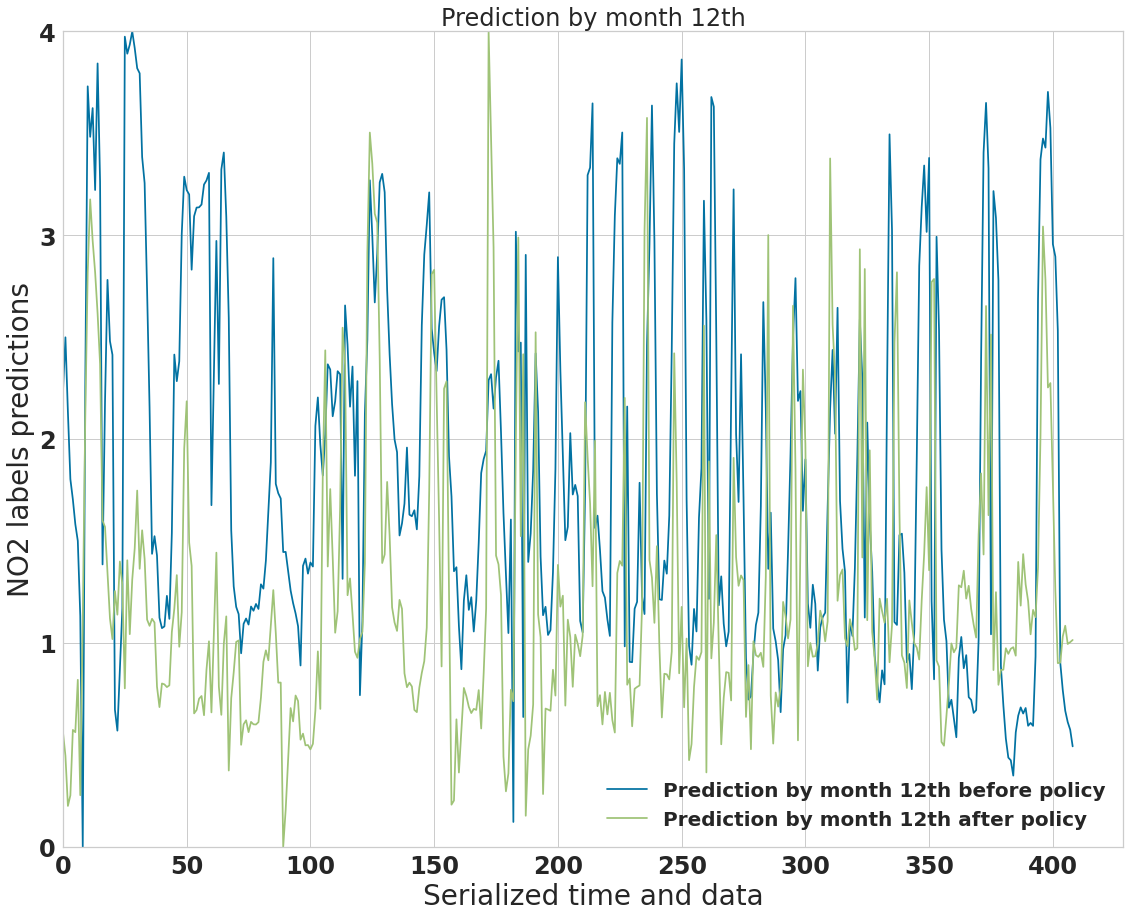

In [ ]:
from IPython.core.pylabtools import figsize
DF18b=pd.read_csv('mix2018.csv')
monthvals=DF18b.month.unique()


tf=DF18b['Traffic Flow'].values
twmv=np.round(tf* 0.0063)
cat=np.round(tf*0.8)
bac=np.round(tf*0.0124)
lgvs=np.round(tf*0.1813)
DF18b['two wheeled motor vehicles']=twmv
DF18b['cars and taxis']=cat
DF18b['buses and coaches']=bac
DF18b['lgvs']=lgvs
DF18b.drop('Traffic Flow',axis=1)
labels2018=DF18b['NO2']
templ2018=set_tags_no2(labels2018)
DF18b.NO2=templ2018
Ys=DF18b["NO2"].values
Ys_of_train=np.zeros_like(Ys)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4

DF18b.NO2=Ys_of_train

#after


DF18a=pd.read_csv('mix2018.csv')
monthvals=DF18a.month.unique()


tf=DF18a['Traffic Flow'].values
twmv=np.round(tf* 0.0063)
cat=np.round(tf*0.8)
bac=np.round(tf*0.0124)
lgvs=np.round(tf*0.1813)
DF18a['two wheeled motor vehicles']=twmv
DF18a['cars and taxis']=cat
DF18a['buses and coaches']=bac
DF18a['lgvs']=lgvs

# 18
twmv18=DF18a["two wheeled motor vehicles"].values
twmv18=np.round(twmv18*0.8)
cat18=DF18a["cars and taxis"].values
cat18=np.round(cat18*0.8)
bac18=DF18a["buses and coaches"].values
bac18=np.round(bac18*0.9)
lgvs18=DF18a["lgvs"].values
lgvs18=np.round(lgvs18*0.8)
co18=DF18a["CO"].values
co18=co18-18
pm2518=DF18a["PM2_5"].values
pm2518=pm2518 -16
par18=DF18a["Particle Count"].values
par18=par18 -10
pm118=DF18a["PM1"].values
pm118=pm118 -10
pm1018=DF18a["PM10"].values
pm1018=pm1018 -21
pm418=DF18a["PM 4"].values
pm418=pm418 -23
o318=DF18a["O3"].values
o318=o318 -29
no18=DF18a["NO"].values
no18=no18 -18
nox18=DF18a["NOx"].values
nox18=nox18 -24
no218=DF18a["NO2"].values
no218=no218 -25


DF18a["two wheeled motor vehicles"]=twmv18
DF18a["cars and taxis"]=cat18
DF18a["buses and coaches"]=bac18
DF18a["lgvs"]=lgvs18
DF18a["CO"]=co18
DF18a["PM2_5"]=pm2518
DF18a["Particle Count"]=par18
DF18a["PM1"]=pm118
DF18a["PM10"]=pm1018
DF18a["PM 4"]=pm418
DF18a["O3"]=o318
DF18a["NO"]=no18
DF18a["NOx"]=nox18
DF18a["NO2"]=no218

labels2018=DF18a['NO2']
templ2018=set_tags_no2(labels2018)
DF18a.NO2=templ2018
Ys=DF18a["NO2"].values
Ys_of_train=np.zeros_like(Ys)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4

DF18a.NO2=Ys_of_train





print(monthvals)
for j in monthvals:
  #before
  tempdf=DF18b.loc[DF2018['month'] == j]
  trainx18=tempdf.drop('NO2', axis=1)
  
  scaler = MinMaxScaler(feature_range=(0, 1))
  values18 = scaler.fit_transform(trainx18)
  trainx18 = series_to_supervised(values18, 1, 1)
  trainlab18=tempdf['NO2'].values

  trainx18=trainx18.values
  trainlab18=trainlab18[:48]
  trainx18 = trainx18.reshape((trainx18.shape[0], 1, trainx18.shape[1]))
  trainx18 =trainx18[:,:,:48]
  yhats = model18.predict(trainx18)
  scaler = MinMaxScaler(feature_range=(0, 4))
  yhats = scaler.fit_transform(yhats)

  #after
  tempdf=DF18a.loc[DF2018['month'] == j]
  trainx18=tempdf.drop('NO2', axis=1)
  
  scaler = MinMaxScaler(feature_range=(0, 1))
  values18 = scaler.fit_transform(trainx18)
  trainx18 = series_to_supervised(values18, 1, 1)
  trainlab18=tempdf['NO2'].values

  trainx18=trainx18.values
  trainlab18=trainlab18[:52]
  trainx18 = trainx18.reshape((trainx18.shape[0], 1, trainx18.shape[1]))
  trainx18 =trainx18[:,:,:52]
  yhats2 = model18a.predict(trainx18)
  scaler = MinMaxScaler(feature_range=(0, 4))
  yhats2 = scaler.fit_transform(yhats2)
  plt.plot(yhats, label='Prediction by month '+str(j)+'th before policy')
  plt.plot(yhats2, label='Prediction by month '+str(j)+'th after policy')
  plt.ylabel('NO2 labels predictions',fontsize=28)
  plt.yticks([0,1,2,3,4])
  plt.xlabel('Serialized time and data',fontsize=28)
  plt.title('Prediction by month '+str(j)+'th')
  plt.ylim(ymin=0,ymax=4)
  plt.xlim(xmin=0)
  plt.legend()
  plt.show()


#air_quality_final

In [ ]:
DF2018=pd.read_csv('mix2018.csv')
DF2018.reset_index(drop=True, inplace=True)
labels2018=DF2018['NO2']
templ2018=set_tags_no2(labels2018)
DF2018.NO2=templ2018
Ys=DF2018["NO2"].values
Ys_of_train=np.zeros_like(Ys)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4

B418=Ys_of_train
DF18=DF2018
DF18.NO2=B418


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


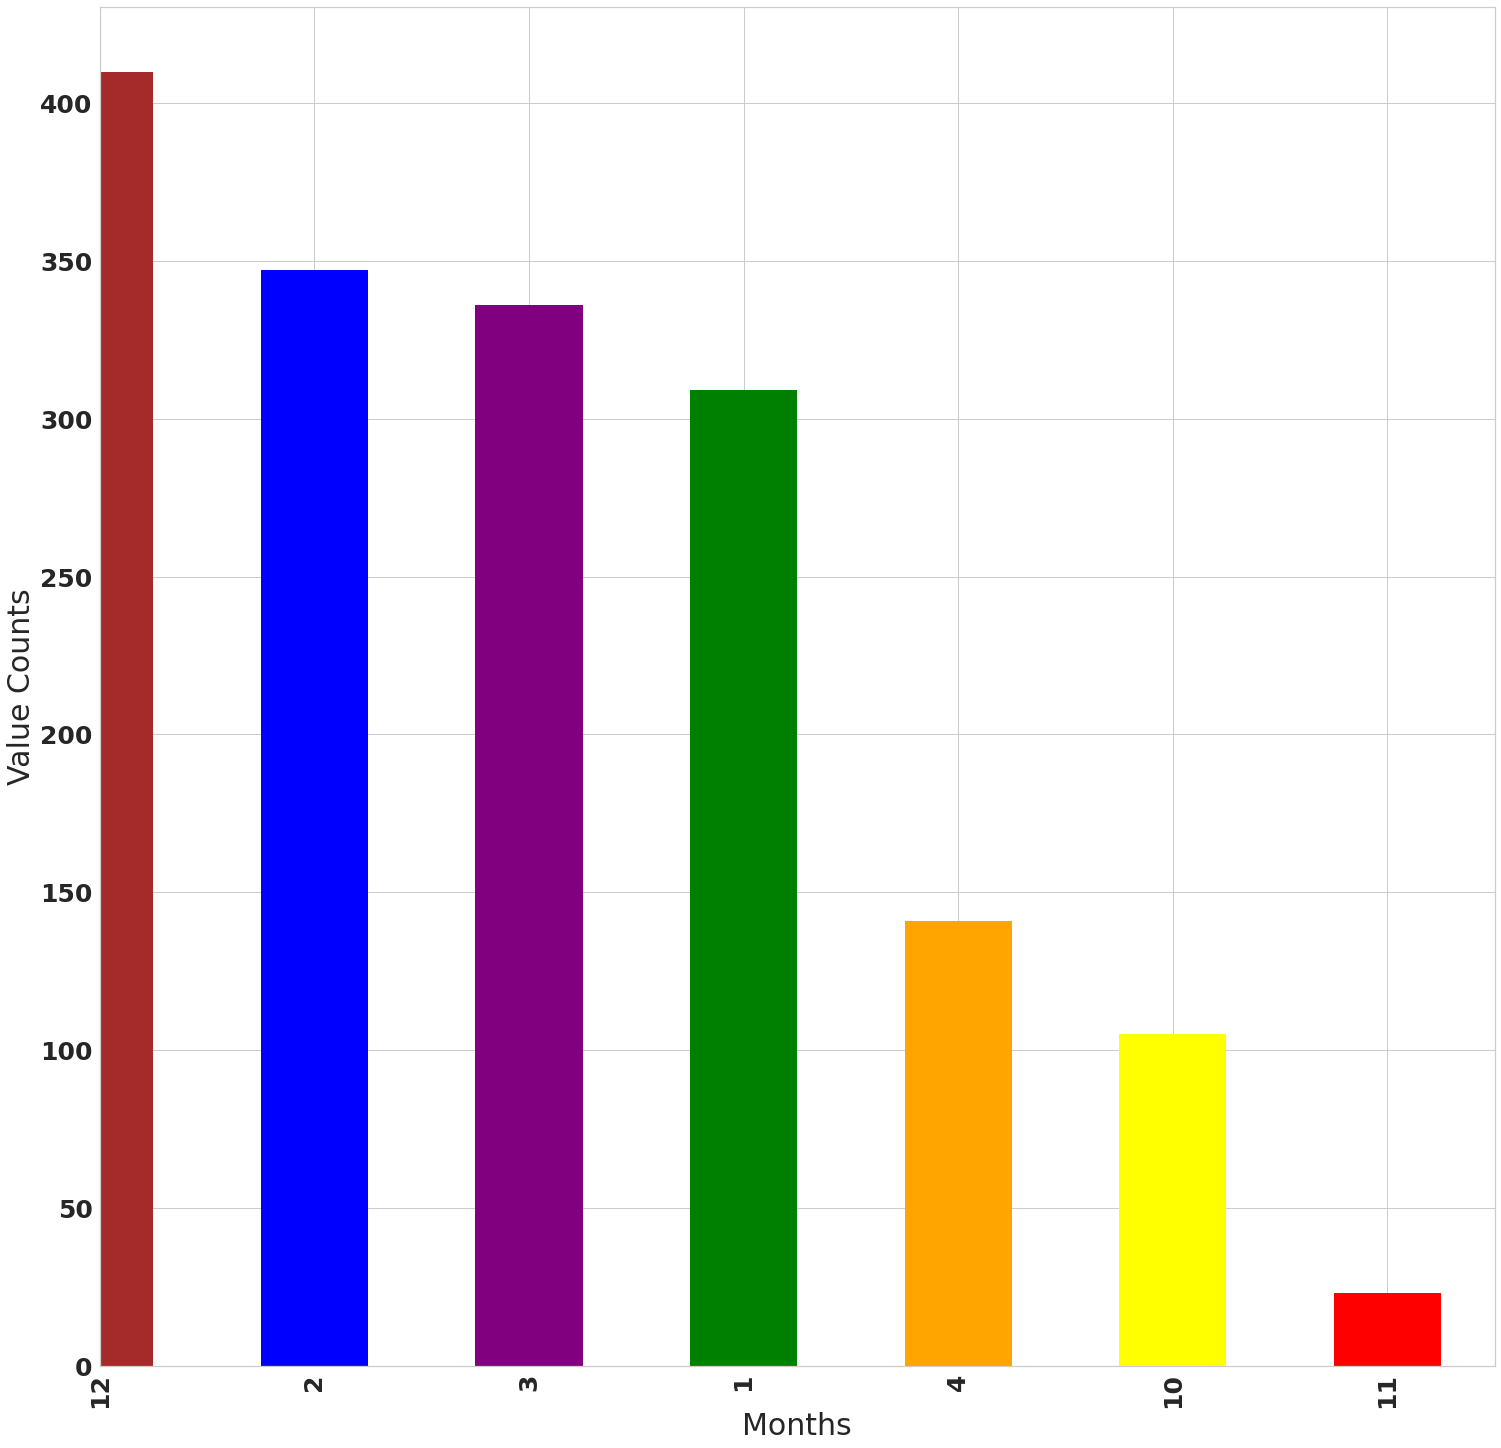

In [ ]:
fig, ax = plt.subplots()
DF2018['month'].value_counts().plot(ax=ax, kind='bar', 
                                    color=['brown', 'blue', 'purple', 'green', 'orange', 'yellow', 'red'],
                                    figsize=(25,25), fontsize=(25))


plt.ylabel('Value Counts',fontsize=(30))
plt.xlabel('Months',fontsize=(30))
plt.xlim(xmin=0)
plt.show()


In [ ]:
DF2018['NO2'].value_counts()

4    624
1    509
0    329
2    146
3     63
Name: NO2, dtype: int64

In [ ]:
DF18.columns

Index(['year', 'month', 'day', 'hour', 'Rain Duration', 'Traffic Flow',
       'Solar Radiation', 'Particle Count', 'Max Wind Speed', 'Average Speed',
       'Solar Diffuse Radiation', 'Congestion', 'O3', 'PM2_5', 'Wind Speed',
       'Pressure', 'Brood', 'NO', 'NOx', 'PM 4', 'PM10', 'Wind Direction',
       'Rain Acc', 'CO', 'PM1', 'NO2'],
      dtype='object')

In [ ]:
# labels, counts = np.unique(DF18.year.values, return_counts=True)
# plt.bar(labels, counts, align='center',color="green")
# plt.xticks([2016,2017,2018,2019,2020])
# plt.ylabel("count")
# plt.xlabel("year")
# plt.xlim(xmin=0)
# plt.show()



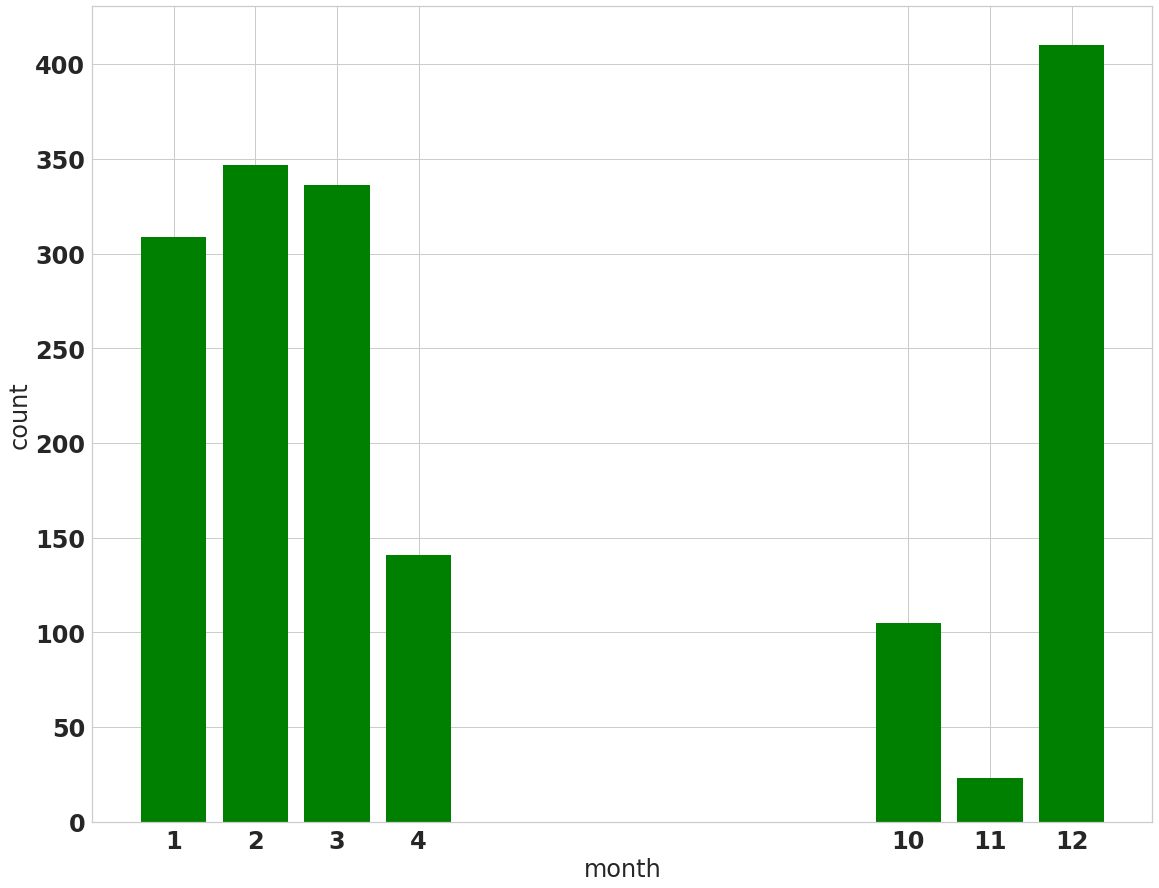

In [ ]:
labels, counts = np.unique(DF18.month.values, return_counts=True)
plt.bar(labels, counts, align='center',color="green")
plt.xticks(labels)
plt.ylabel("count")
plt.xlabel("month")
plt.xlim(xmin=0)
plt.show()

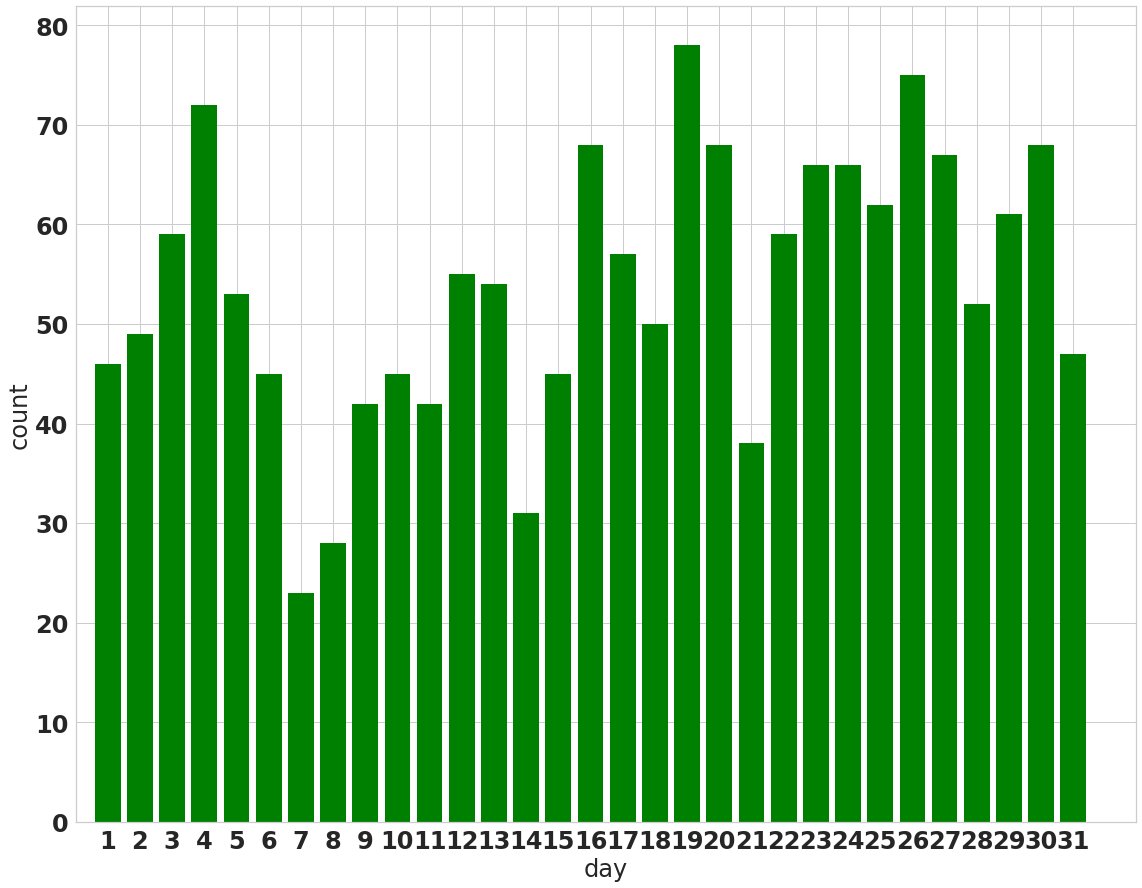

In [ ]:
labels, counts = np.unique(DF18.day.values, return_counts=True)
plt.bar(labels, counts, align='center',color="green")
plt.xticks(labels)
plt.ylabel("count")
plt.xlabel("day")
plt.xlim(xmin=0)
plt.show()



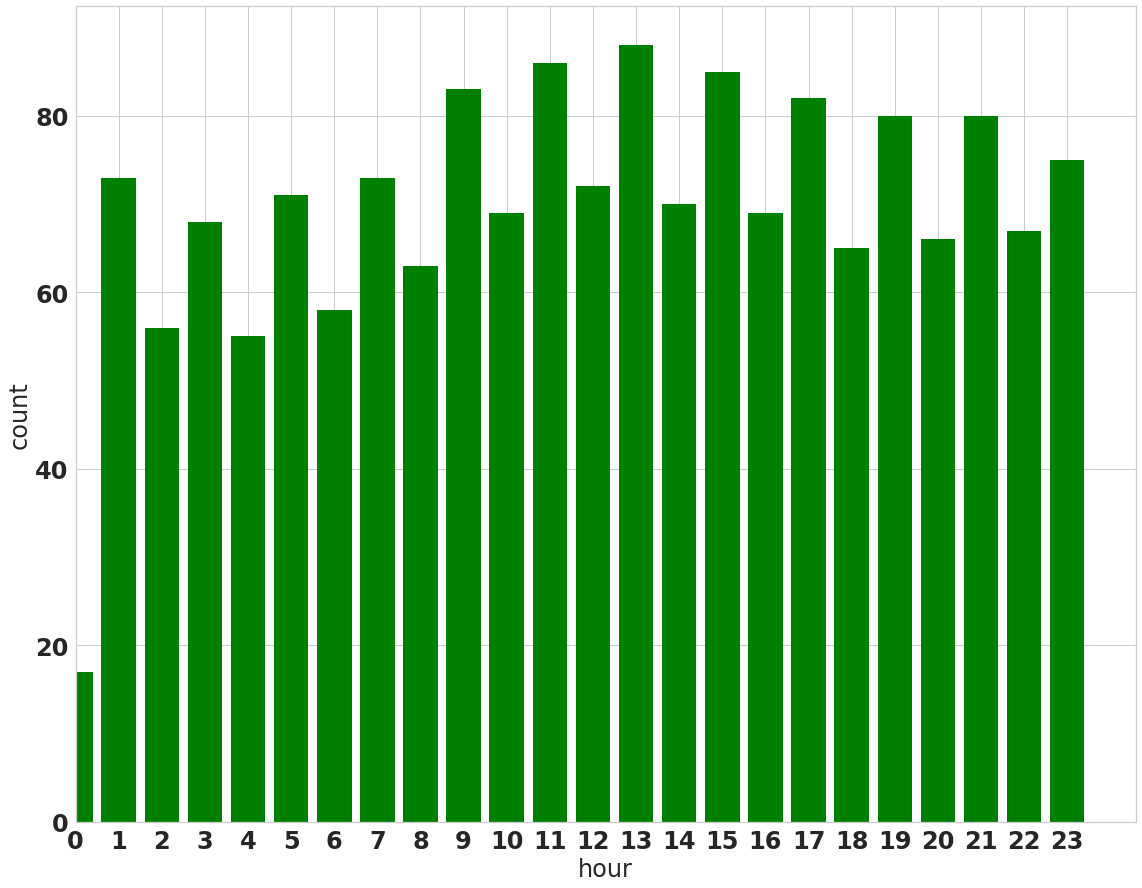

In [ ]:
labels, counts = np.unique(DF18.hour.values, return_counts=True)
plt.bar(labels, counts, align='center',color="green")
plt.xticks(labels)
plt.ylabel("count")
plt.xlabel("hour")
plt.xlim(xmin=0)
plt.show()



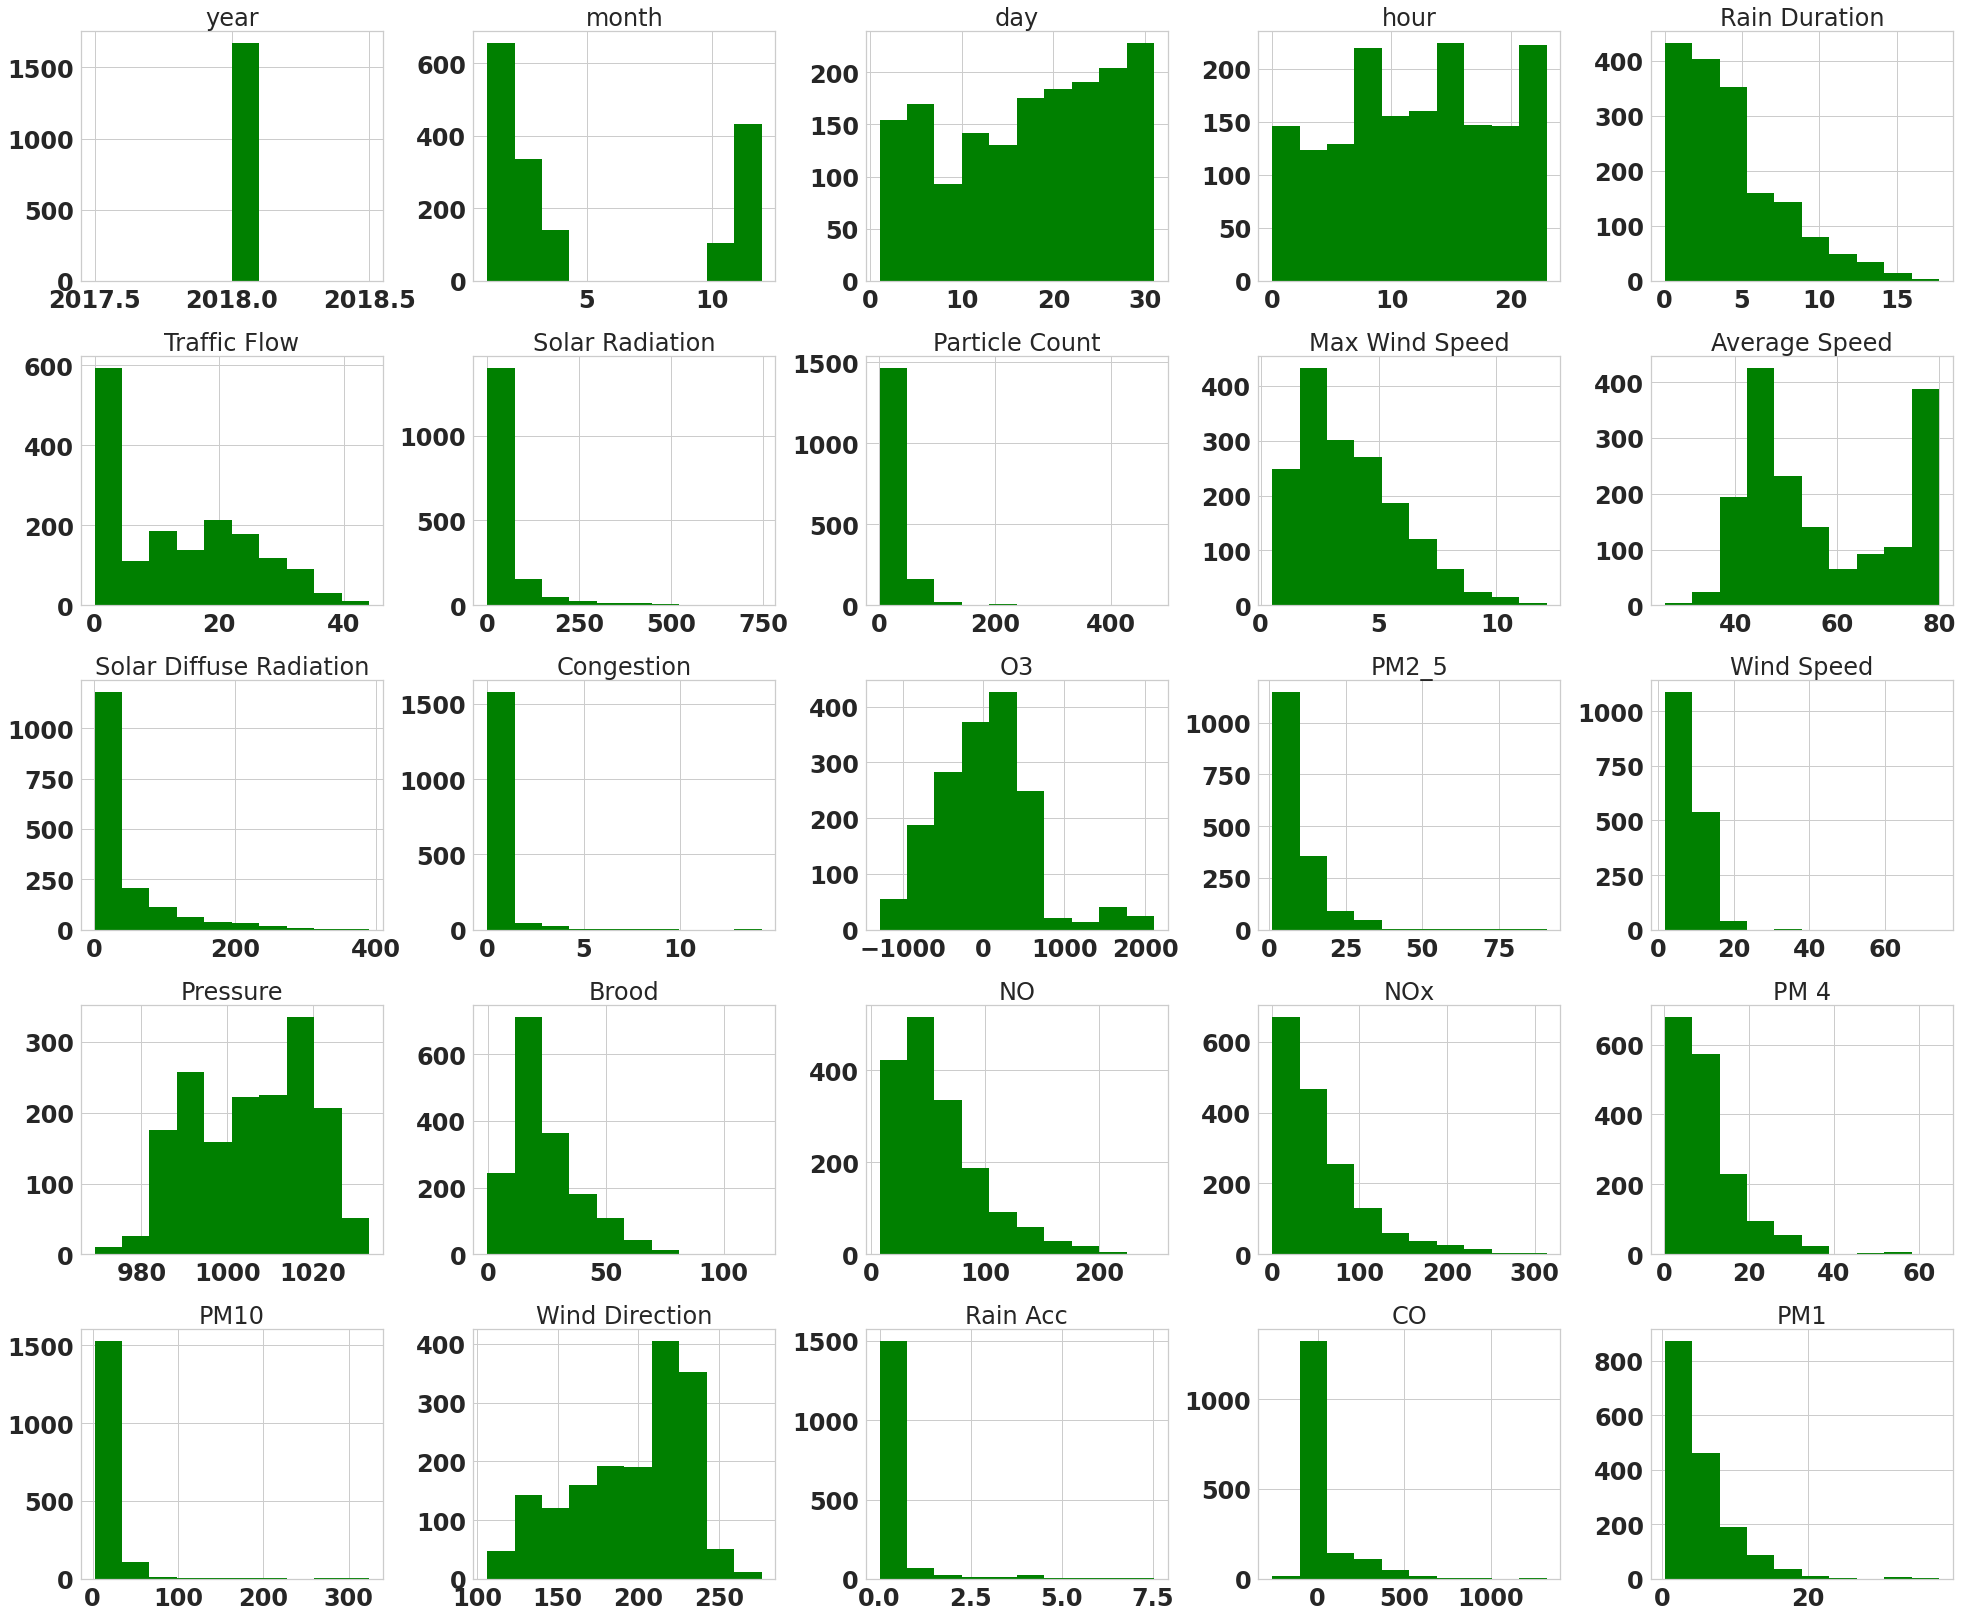

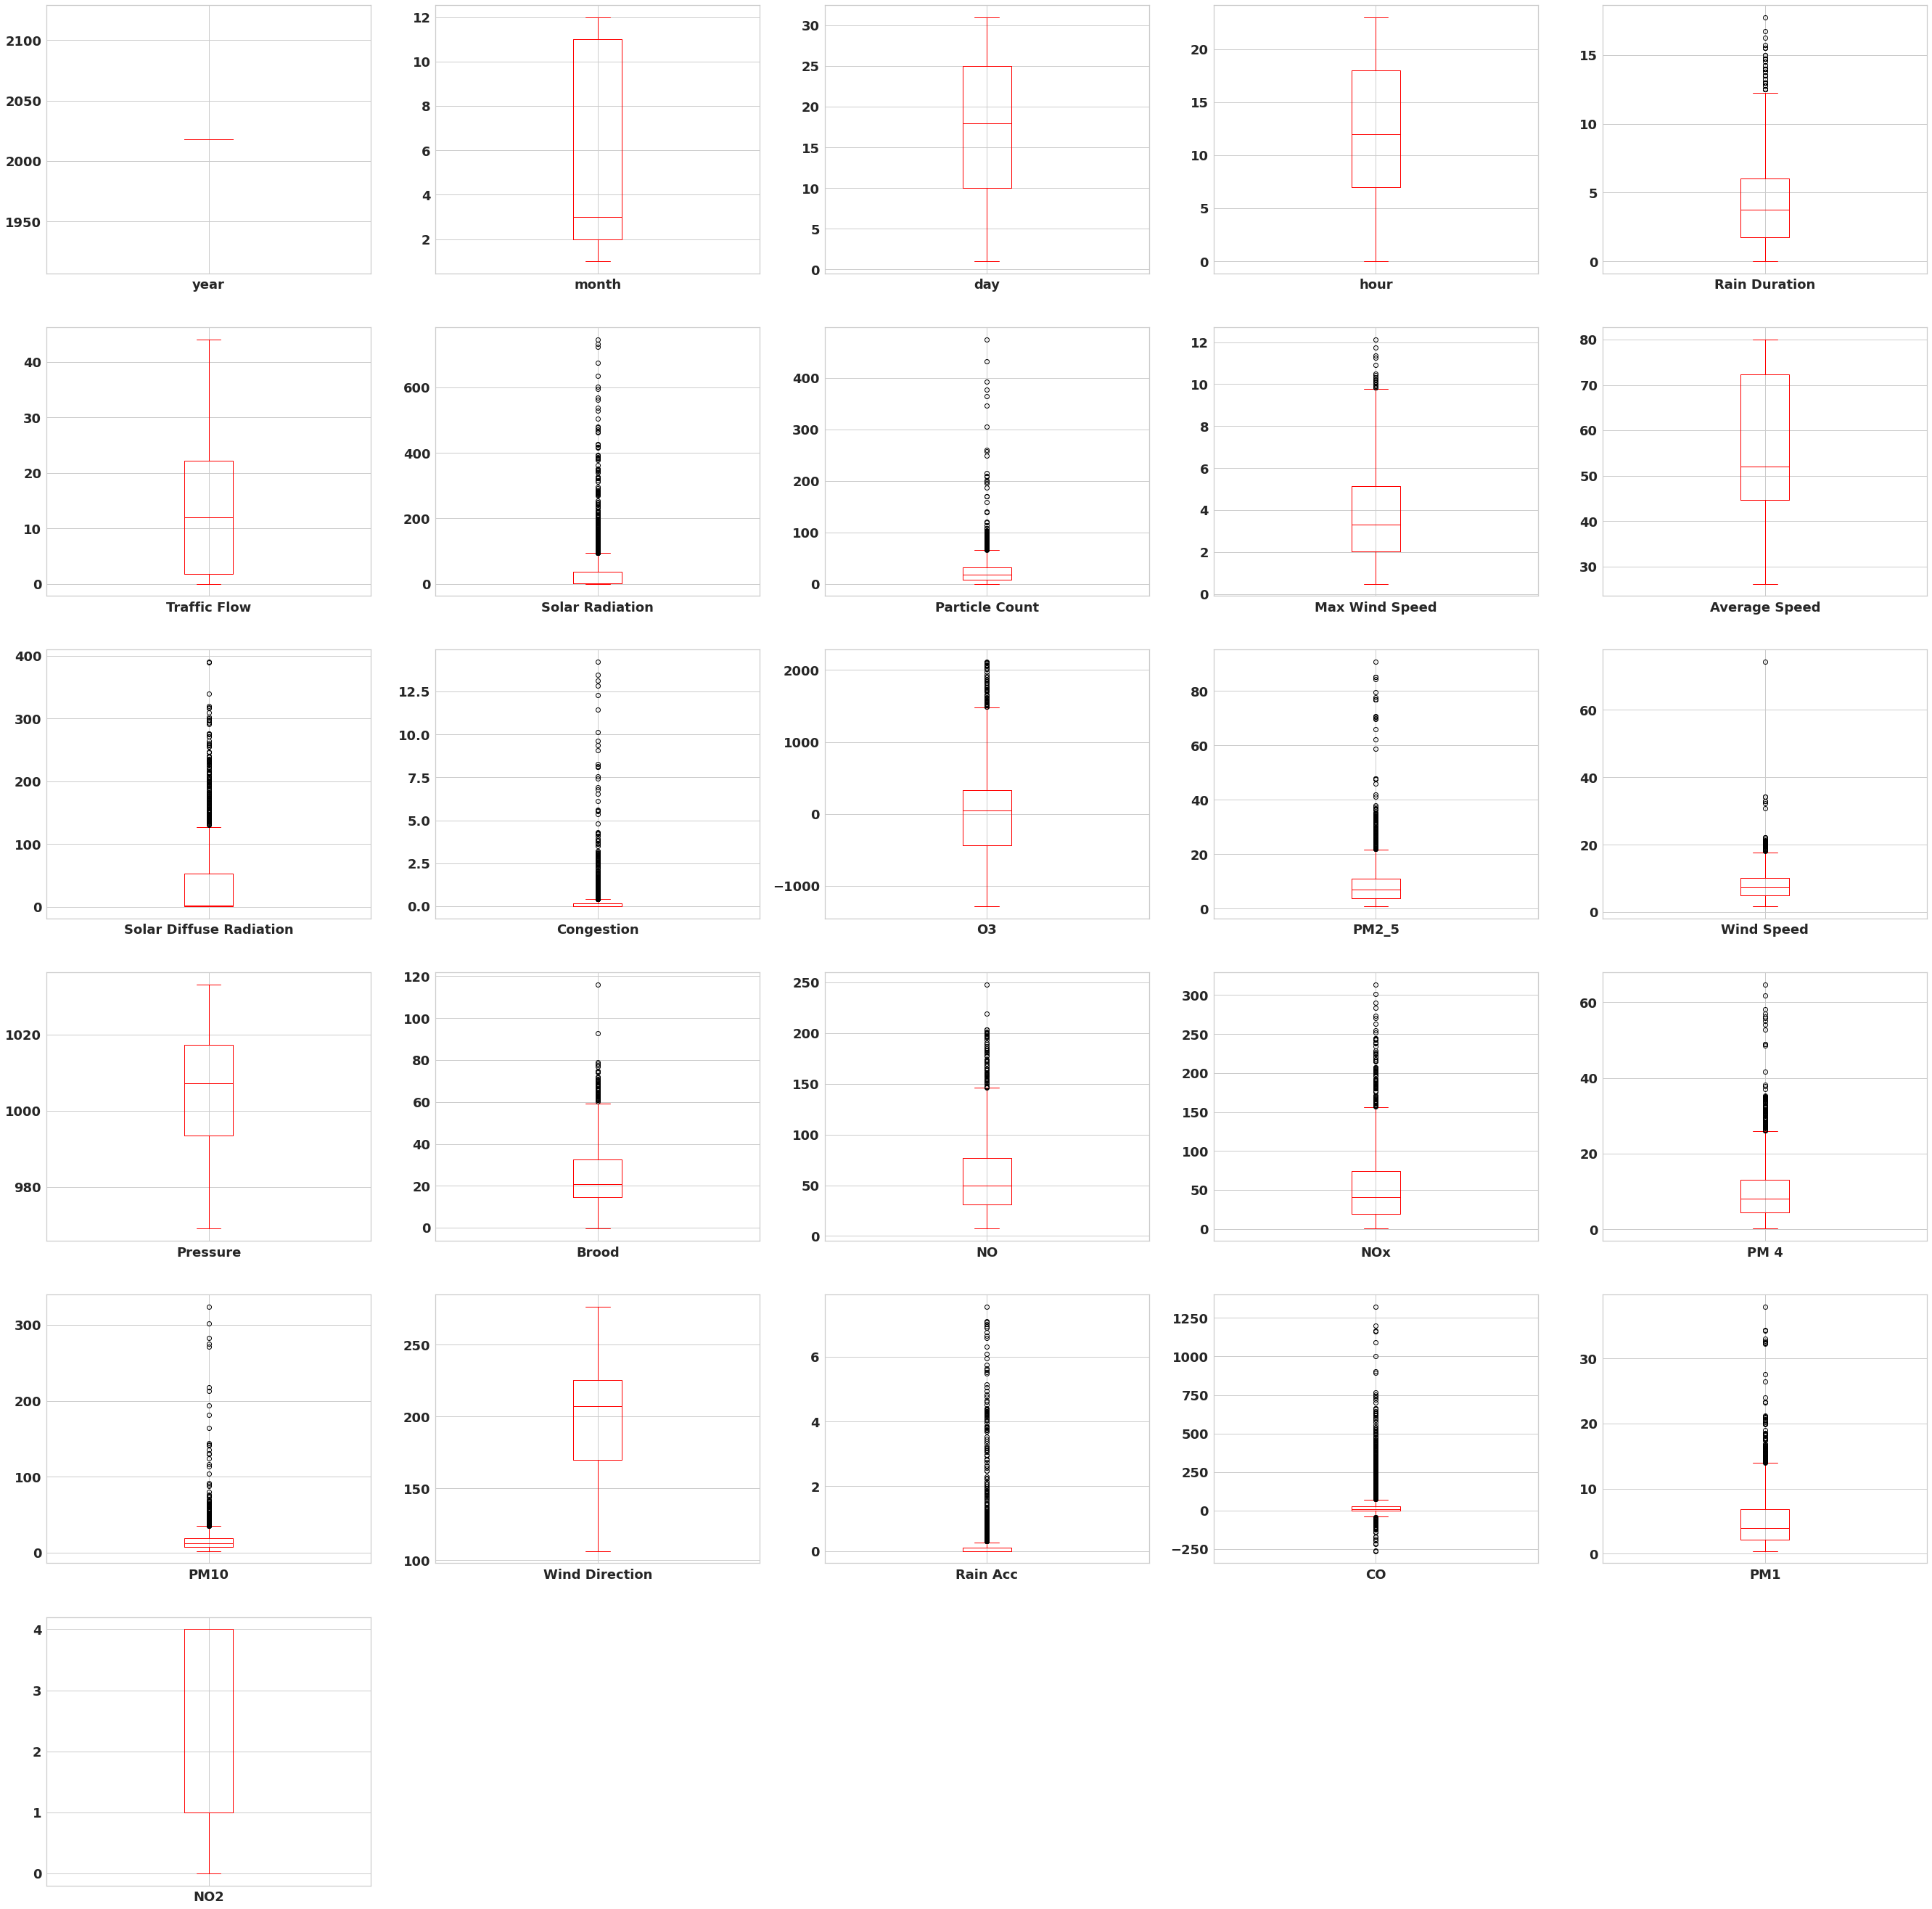

In [ ]:
DF2018.hist(figsize=(26,26), layout=(6,5), color = 'green')
plt.xticks(fontsize=10)
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22}
# plot.rc('font', **font)
plt.xlim(xmin=0)
plt.subplots_adjust(left=4, bottom=4, right=5, top=5)
plt.show()



# #print quartile plot for outlier detection
DF2018.plot(kind='box', subplots=True, figsize=(36,36), layout=(6,5),
            sharex=False, sharey=False, fontsize=(18), color='red')
plt.subplots_adjust(left=4, bottom=4, right=5, top=5)
plt.show()